# Problem Set 4 (PSet 4): Federated Learning and Text-to-Image Generation




> Harvard CS 2420: Computing at Scale (Fall 2025)

>
> Instructor: Professor HT Kung


Team #: 16

Team Members:
- Ben Willhite
- Zoe Wu
- Owen Jin


### **Assignment Instructions**

**Please start this assignment early.**

Please read the following instructions carefully before starting the assignment and again before submitting your work:

* Please enter your team number and the names of all team members in the text cell above.
* We expect this assignment to take more time. There is a more significant programming element involved, and more training time is required for the models. **Again, we suggest you start right away.**
* The assignment consists of two parts: **this Google Colab file** (an `.ipynb `file) and a **LaTeX answer template** (available on Canvas).
* The Google Colab contains all assignment instructions and *Code Cells* that you will use to implement the programming components of the assignment in Python. **(Note: if there are any wording differences between the LaTeX template and this Colab file, the Colab file is authoritative and takes precedence.)**
* We provide a significant amount of the code to make it easier to get started. In the *Code Cells*, please add comments to explain the purpose of each line of code in your implementation. **You will not receive credit for implementations that are not well-documented.**
* <font color='red'>**Deliverables are highlighted in red**</font> in this Google Colab file. Use the LaTeX answer template to write down answers for these deliverables.
* Each group will **submit** both a PDF of your answers, any logs from generative AI, and your Google Colab file (`.ipynb` file) containing all completed *Code cells* to "Problem Set 4" on Canvas. Only one submission per group. Check your `.ipynb` file using this [tool](https://htmtopdf.herokuapp.com/ipynbviewer/) before submitting to ensure that you completed all *Code Cells* (including detailed comments).
* The assignment is due on **Wednesday, November 5, 2025 at 11:59 PM EST**.
* Each part you are asked to implement is relatively small in isolation, and should be easy to test. We strongly recommend you test each of these parts before training the large models as to not waste time training models with buggy implementations. For example, you should ensure that your sampling is being done correctly, otherwise the model will still train, but your results will not be correct. For a number of sections, we have provided checks you can run to ensure correctness prior to training a large model.

-----
An outline of this assignment with point values and training estimates is given below. Note that these estimates represent a lower bound on the running time, assuming a correct implementation.

1. **Exploring Federated Learning (FL)** [25 points] [Training Estimate: 2 hours]

2. **Non-IID Federated Learning and Fairness** [30 points] [Training Estimate: 3 hours]

3. **Quantization of Local Models for Reduced Communication Cost** [25 points] [Training Estimate: 3 hours]

4. **Backdoor Attacks by Malicious Clients and Defenses** [15 points] [Training Estimate: 1.5 hours]

5. **Fine-Tune a Large Pre-Trained Stable Diffusion Model to Learn a New Concept** [25 points] [Training Estimate 1-2 hours]

6. **Training-Free Multi-Prompt Generation with Varied Resolutions (Inference-Time)** [30 points]




---



> ## 💾 **Remember to Save Your Outputs**
>
> Colab runtimes can **reset or disconnect** after installs, version changes, or idle time.  
> To prevent data loss, **save your results frequently** to Google Drive or download them.



---



## ⚙️ Prerequisites
Please install the following libraries before you start this assignment

In [1]:
# --- Setup & Prerequisites (macOS + MPS, no CUDA/xFormers) ---

# 0) Remove CUDA-only extras if they were previously pulled
#    (safe no-ops if not installed)
%pip uninstall -y xformers bitsandbytes -q || True

# 1) Install PyTorch for macOS (MPS backend). No CUDA index.
%pip install -q torch==2.5.1 torchvision==0.20.1 torchaudio==2.5.1

# 2) Core libraries from the notebook (keep your pinned versions)
%pip install -q diffusers==0.30.3 transformers==4.44.2 accelerate==0.34.2 matplotlib

# Optional (handy in VS Code/Jupyter): ensure this env is a selectable kernel
# %pip install -q ipykernel
# import sys, subprocess; subprocess.run([sys.executable, "-m", "ipykernel", "install", "--user", "--name", "mps-env", "--display-name", "Python (mps-env)"])

# Quick peek
import torch, torchvision
print("Torch:", torch.__version__, "| TorchVision:", torchvision.__version__)
print("CUDA available:", torch.cuda.is_available())
print("MPS available:", torch.backends.mps.is_available())

print("\n>>> NOTE: On Mac, training uses the MPS backend (no CUDA).")


Torch: 2.5.1 | TorchVision: 0.20.1
CUDA available: False
MPS available: True

>>> NOTE: On Mac, training uses the MPS backend (no CUDA).


In [2]:
# --- Check Installed Libraries (run AFTER the setup cell) ---
import re, os, torch
import diffusers, transformers, accelerate

# TorchVision: binary add-on; will fail only if misaligned with torch
try:
    import torchvision
    tv_version = torchvision.__version__
    tv_ok = True
except Exception as e:
    tv_version = f"import failed: {type(e).__name__}: {e}"
    tv_ok = False

# xFormers (optional on macOS/MPS). Report status if present, but don't require it.
try:
    import xformers, xformers.ops
    xformers_version = xformers.__version__
    x_ok = True
except Exception as e:
    xformers_version = f"not installed (OK on MPS): {type(e).__name__}: {e}"
    x_ok = False

def vtuple(v):
    nums = re.findall(r"\d+", v)[:3]
    nums += ["0"] * (3 - len(nums))
    return tuple(int(x) for x in nums)

need = {
    "torch":        (2, 5, 1),
    "diffusers":    (0, 30, 3),
    "transformers": (4, 44, 2),
    "accelerate":   (0, 34, 2),
}

have = {
    "torch":        vtuple(torch.__version__),
    "diffusers":    vtuple(diffusers.__version__),
    "transformers": vtuple(transformers.__version__),
    "accelerate":   vtuple(accelerate.__version__),
}

print("Detected:")
print(f"  PyTorch:      {torch.__version__}   "
      f"(CUDA available: {torch.cuda.is_available()} | MPS available: {torch.backends.mps.is_available()})")
print(f"  TorchVision:  {tv_version}")
print(f"  Diffusers:    {diffusers.__version__}")
print(f"  Transformers: {transformers.__version__}")
print(f"  Accelerate:   {accelerate.__version__}")
print(f"  xFormers:     {xformers_version}")

print("\nEnvironment check:")
for k, req in need.items():
    status = "OK ✅" if have[k] >= req else "WARN ⚠️"
    print(f"  {k:12s} {status} (have {have[k]}, need ≥ {req})")

if not tv_ok:
    print("\nTorchVision import failed → Torch/TorchVision misaligned.")
    print("Re-run the Setup cell to repair.")

if not torch.backends.mps.is_available():
    print("\nMPS not available → running on CPU. On Apple Silicon, install the macOS PyTorch wheels and run a native arm64 Python.")
    print("See: https://docs.pytorch.org/docs/stable/notes/mps.html")


Detected:
  PyTorch:      2.5.1   (CUDA available: False | MPS available: True)
  TorchVision:  0.20.1
  Diffusers:    0.30.3
  Transformers: 4.44.2
  Accelerate:   0.34.2
  xFormers:     not installed (OK on MPS): ModuleNotFoundError: No module named 'xformers'

Environment check:
  torch        OK ✅ (have (2, 5, 1), need ≥ (2, 5, 1))
  diffusers    OK ✅ (have (0, 30, 3), need ≥ (0, 30, 3))
  transformers OK ✅ (have (4, 44, 2), need ≥ (4, 44, 2))
  accelerate   OK ✅ (have (0, 34, 2), need ≥ (0, 34, 2))


---

### **1. Exploring Federated Learning (FL)**

---
We will be using a dataset (CIFAR-10) and CNN model (`ConvNet`) introduced in Programming Assignment 2. *Code Cell 1.1* creates the CIFAR-10 training and testing datasets. Additionally, it also contains the CNN (`ConvNet`)  that will be used throughout the assignment.

In [3]:
## Code Cell 1.1

import time
import copy
import sys
from collections import OrderedDict

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import numpy as np
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

# added this little helper here to allow for local runs on macs, to get around disconnect issue. 
ACCEL = ("cuda" if torch.cuda.is_available()
         else "mps" if torch.backends.mps.is_available()
         else "cpu")

# Using CIFAR-10 again as in Assignment 2
# Load training data
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True,
                                        transform=transform_train)

# Load testing data
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True,
                                       transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=128, shuffle=False)


# Using same ConvNet as in Assignment 2
def conv_block(in_channels, out_channels, kernel_size=3, stride=1,
               padding=1):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding,
                  bias=False),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True)
        )

class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.model = nn.Sequential(
            conv_block(3, 32),
            conv_block(32, 32),
            conv_block(32, 64, stride=2),
            conv_block(64, 64),
            conv_block(64, 64),
            conv_block(64, 128, stride=2),
            conv_block(128, 128),
            conv_block(128, 256),
            conv_block(256, 256),
            nn.AdaptiveAvgPool2d(1)
            )

        self.classifier = nn.Linear(256, 10)

    def forward(self, x):
        h = self.model(x)
        B, C, _, _ = h.shape
        h = h.view(B, C)
        return self.classifier(h)


100%|██████████| 170M/170M [00:03<00:00, 47.1MB/s] 


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


**Federated Learning Overview**

Federated Learning (FL) distributes the task of training a deep neural network (such as our CNN `ConvNet`) across multiple client devices. Each client may have private data they do not want to share with a central server. Therefore, instead of transmitting data, clients perform training locally and send the updated model parameters (e.g., convolutional weights) to the server. The server averages these parameters across multiple clients to update the centralized model. Finally, after the centralized model has been updated, the server sends the new version of the model to all clients.

The figure below depicts this Federated Learning paradigm (taken from [Towards Federated Learning at Scale: System Design](https://arxiv.org/pdf/1902.01046.pdf)). At the beginning of a training round in the selection phase, a percentage of devices (i.e., clients) agree to participate. By agreeing to participate, a client agrees to perform local training with its own dataset that resides on the device. During the configuration phase, the up-to-date centralized model is sent to the participating clients, which then perform local training. In the reporting phase, each client sends their own updated model (trained using local data) to the server for aggregation. Note that, in the figure, one of the clients fails to report back to the central server (either due to device or network failure). To simplify this assignment, we will assume this type of device/network failure is not possible.

<figure>
<center>
<img src='https://drive.google.com/uc?id=1y8HAIxtNaZVLWetXHEzJ4UXWJ0yX_Jo0' />
</figure>


**Simulating Federated Learning**

In this assignment, we will simulate this distributed Federated Learning environment on a single machine (i.e., a Colab instance). Each `device` will own a subset (or partition) of the dataset (e.g., 10% of the CIFAR-10 training set) and use it to train a local version of the model. The main difference between this simulated environment and a real system is the lack of networking between devices.

You will use the `DatasetSplit` class in *Code Cell 1.2* to create subsets of the full training dataset. The `create_device` function creates a unique instance of `ConvNet`, an instance of the `DatasetSplit` dataloader, and an optimizer and scheduler for training. This function will be called multiple times (once per device) to create all the required device instances used for Federated Learning. The `train` and `test` functions are a modified version from Assignment 2 that take a device argument (the output from `create_device`. The batch size during training is set to 128 throughout the assignment. This is passed into the `create_device` function as a default parameter value (i.e., `batch_size=128`).

In [4]:
## Code Cell 1.2
import copy

class DatasetSplit(torch.utils.data.Dataset):
    def __init__(self, dataset, idxs):
        self.dataset = dataset
        self.idxs = [int(i) for i in idxs]

    def __len__(self):
        return len(self.idxs)

    def __getitem__(self, item):
        image, label = self.dataset[self.idxs[item]]
        return image, torch.tensor(label)

def create_device(net, device_id, trainset, data_idxs, lr=0.1,
                  milestones=None, batch_size=128):
    if milestones == None:
        milestones = [25, 50, 75]

    device_net = copy.deepcopy(net)
    optimizer = torch.optim.SGD(device_net.parameters(), lr=lr, momentum=0.9)
    scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer,
                                                     milestones=milestones,
                                                     gamma=0.1)
    device_trainset = DatasetSplit(trainset, data_idxs)
    device_trainloader = torch.utils.data.DataLoader(device_trainset,
                                                     batch_size=batch_size,
                                                     shuffle=True)
    return {
        'net': device_net,
        'id': device_id,
        'dataloader': device_trainloader,
        'optimizer': optimizer,
        'scheduler': scheduler,
        'train_loss_tracker': [],
        'train_acc_tracker': [],
        'test_loss_tracker': [],
        'test_acc_tracker': [],
        }

def train(epoch, device):
    net.train()
    device['net'].train()
    train_loss, correct, total = 0, 0, 0
    for batch_idx, (inputs, targets) in enumerate(device['dataloader']):
        inputs, targets = inputs.to(ACCEL), targets.to(ACCEL)
        device['optimizer'].zero_grad()
        outputs = device['net'](inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        device['optimizer'].step()
        train_loss += loss.item()
        device['train_loss_tracker'].append(loss.item())
        loss = train_loss / (batch_idx + 1)
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
        acc = 100. * correct / total
        dev_id = device['id']
        sys.stdout.write(f'\r(Device {dev_id}/Epoch {epoch}) ' +
                         f'Train Loss: {loss:.3f} | Train Acc: {acc:.3f}')
        sys.stdout.flush()
    device['train_acc_tracker'].append(acc)
    sys.stdout.flush()

def test(epoch, device):
    net.eval()
    test_loss, correct, total = 0, 0, 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            inputs, targets = inputs.to(ACCEL), targets.to(ACCEL)
            outputs = device['net'](inputs)
            loss = criterion(outputs, targets)
            test_loss += loss.item()
            device['test_loss_tracker'].append(loss.item())
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
            loss = test_loss / (batch_idx + 1)
            acc = 100.* correct / total
    sys.stdout.write(f' | Test Loss: {loss:.3f} | Test Acc: {acc:.3f}\n')
    sys.stdout.flush()
    acc = 100.*correct/total
    device['test_acc_tracker'].append(acc)

**Single Device Scenario**

Before implementing Federated Learning, we will train a model for a single client device using only local data without sending updates to a central server. By doing this, the device is only able to look at a small percentage of the CIFAR-10 training set (10% in this case), and should perform poorly.

---
<font color='red'>**PART 1.1:**</font> [5 points]

<font color='red'>**Deliverables**</font>
1. In *Code Cell 1.3*, implement the function `iid_sampler` to generate **IID** (independent and identically distributed) samples from the CIFAR-10 training set. We will use this function to generate training subsets for multiple devices in **PART 1.2**.
2. In *Code Cell 1.4*, create a single device using the function `create_device`. This device should have 10% of the CIFAR-10 training set, obtained using `iid_sampler`.
3. Train the model for 1000 epochs using the parameters specified in *Code Cell 1.4* (similar to Assignment 2). The number of epochs is 10x greater due to the single device having only 10% of the data. Plot the test accuracy (`device['test_acc_tracker']`) over the epochs and comment on the classification accuracy compared to using 100% of the dataset as in Assignment 2. (50 words maximum)
---

In [5]:
## Code Cell 1.3

# helpful little imports for the function
import math, random
from typing import Dict, List

def iid_sampler(dataset, num_devices, data_pct):
    '''
    dataset: PyTorch Dataset (e.g., CIFAR-10 training set)
    num_devices: integer number of devices to create subsets for
    data_pct: percentage of training samples to give each device
              e.g., 0.1 represents 10%

    return: a dictionary of the following format:
      {
        0: [3, 65, 2233, ..., 22] // device 0 sample indexes
        1: [0, 2, 4, ..., 583] // device 1 sample indexes
        ...
      }

    iid (independent and identically distributed) means that the indexes
    should be drawn independently in a uniformly random fashion.
    '''

    # total number of samples in the dataset
    total_samples = len(dataset)

    # Part 1.1: Implement!

    # get all indices from dataset, determine how many indices per device
    indices = list(range(total_samples))
    per_device = max(0, math.floor(data_pct * total_samples))

    # iid will need random assignment for the indices assigned to each device
    rnd = random.Random()

    # return in the format 0: [array of indices], 1: [....], n: [...]
    sampled = {n: rnd.choices(indices, k=per_device) for n in range(num_devices)}

    return sampled


Now, perform training using a single device on a subset of the training dataset using your `iid_sampler`:



In [6]:
## Code Cell 1.4


data_pct = 0.1
epochs = 1000 # Part 1.1: Change to 1000 epochs
num_devices = 1
device_pct = 0.1
net = ConvNet().to(ACCEL)
criterion = nn.CrossEntropyLoss()
milestones = [250, 500, 750]

# Part 1.1: Implement the cifar iid_sampler to generate data_idxs for create_device
data_idxs = iid_sampler(trainset, num_devices, data_pct)

# Part 1.1: Create the device

# we can sub in the values above, or for some, we just explicitly assign the defaults here for clarity
device = create_device(
    net = net,
    device_id = 0,
    trainset = trainset,
    data_idxs = data_idxs[0],
    lr = 0.1,
    milestones = milestones,
    batch_size = 128
)

# Part 1.1: Train the device model for 100 epochs and plot the result
# Standard Training Loop
start_time = time.time()
for epoch in range(epochs):
    train(epoch, device)
    # To speed up running time, only evaluate the test set every 10 epochs
    if epoch > 0 and epoch % 10 == 0:
        test(epoch, device)
    device['scheduler'].step()


total_time = time.time() - start_time
print('Total training time: {} seconds'.format(total_time))

(Device 0/Epoch 10) Train Loss: 1.332 | Train Acc: 51.300 | Test Loss: 1.470 | Test Acc: 46.480
(Device 0/Epoch 20) Train Loss: 0.974 | Train Acc: 64.740 | Test Loss: 1.288 | Test Acc: 56.040
(Device 0/Epoch 30) Train Loss: 0.740 | Train Acc: 73.640 | Test Loss: 1.147 | Test Acc: 61.470
(Device 0/Epoch 40) Train Loss: 0.589 | Train Acc: 78.560 | Test Loss: 1.129 | Test Acc: 64.670
(Device 0/Epoch 50) Train Loss: 0.473 | Train Acc: 84.440 | Test Loss: 1.236 | Test Acc: 64.150
(Device 0/Epoch 60) Train Loss: 0.285 | Train Acc: 90.460 | Test Loss: 1.232 | Test Acc: 66.840
(Device 0/Epoch 70) Train Loss: 0.257 | Train Acc: 91.680 | Test Loss: 1.298 | Test Acc: 65.920
(Device 0/Epoch 80) Train Loss: 0.193 | Train Acc: 93.780 | Test Loss: 1.255 | Test Acc: 67.920
(Device 0/Epoch 90) Train Loss: 0.159 | Train Acc: 94.740 | Test Loss: 1.334 | Test Acc: 68.410
(Device 0/Epoch 100) Train Loss: 0.267 | Train Acc: 90.740 | Test Loss: 1.332 | Test Acc: 67.920
(Device 0/Epoch 110) Train Loss: 0.192 

**Implementing Components for Federated Learning**

In **PART 1.1**, you implemented `iid_sampler`, created a 10% subset of the CIFAR-10 training set, and used it to train a single client device model. Since the client only had a 10% subset of the full CIFAR-10 training set, it performed significantly worse than the same model trained on the entire training set.

Federated Learning aims to improve the performance of these client devices by averaging the updates from multiple clients over the course of training. This way, a centralized server is able to be updated using the training data stored on local devices without having access to the training data.
By using more client devices, you will be able to leverage the entire dataset.
In a way, this simulates traditional gradient descent, but with additional epochs performed on each client before averaging, where each epoch uses mini-batches of size 128.
An additional benefit of federated learning is that the centralized server does not require large compute resources, as most of the training computation is performed on local devices.
This makes the training computation "free" for the centralized server, as the clients pay the compute cost on their local devices.

---
<font color='red'>**PART 1.2:**</font> [10 points]

Before implementing Federated Learning, you must implement two functions which will be used during the training process.

The `average_weights` function takes in multiple device models, and computes the average for each model parameter across all models. This function will be called by the centralized server to aggregate the training performed by the end user devices. This averaging is done in 32-bit floating point (`float32`).

The `get_devices_for_round` function will be used to simulate the device rejection phase shown earlier in the figure in the **Federated Learning Overview** section. This function will select a percentage of devices to participate in each training round.

<font color='red'>**Deliverables**</font>
1. In *Code Cell 1.5*, implement `average_weights`. We have provided test code you can use to validate your implementation. This test code will also be useful for the full implementation of Federated Learning in **PART 1.3**.
2. In *Code Cell 1.5*, implement the `get_devices_for_round` function. Try multiple `device_pct` settings to ensure that it is working properly.
---

In [11]:
## Code Cell 1.5
import copy


def average_weights(devices):
    '''
    devices: a list of devices generated by create_devices
    Returns an the average of the weights.
    '''
    # Part 1.2: Implement!
    # Hint: device['net'].state_dict() will return an OrderedDict of all
    #       tensors in the model. Return the average of each tensor using
    #       and OrderedDict so that you can update the global model using
    #       device['net'].load_state_dict(w_avg), where w_avg is the
    #       averaged OrderedDict over all devices

    starting_device = devices[0]['net'].state_dict()
    num_devices = len(devices)

    # we first create two ordered dicts. one for the avg operations, the other for our final list we return
    acc = OrderedDict()
    list_dict = OrderedDict()

    for name, tensor in starting_device.items():
      if tensor.is_floating_point():
        acc[name] = torch.zeros_like(tensor, dtype = torch.float32, device = 'cpu')

    # we wrap our adding and averaging here with no_grad so we don't end up training / retraining during our calls.
    with torch.no_grad():

        # first, we initialize empty set of weights w/ the right dtype (float32)
        for device in devices:
            current = device['net'].state_dict()
            for name, tensor in current.items():
                if tensor.is_floating_point():
                    acc[name] += tensor.detach().to(dtype = torch.float32, device = 'cpu')

        # then, we update the averages as necessary, only the ones that we need, which will have float32 from the previous step
        for name, tensor in starting_device.items():
            if tensor.is_floating_point():
                avg = acc[name] / num_devices
                list_dict[name] = avg.to(dtype=tensor.dtype)
            else: 
                list_dict[name] = tensor.detach().cpu()

    return list_dict



def get_devices_for_round(devices, device_pct):
    '''
    '''

    # Part 1.2: Implement!

    # get total # of active devices for the given device_pct, rounded for cleanliness
    active_devices = device_pct * len(devices)
    active_devices = min(active_devices, len(devices)) # to protect against overly large inputs for device_pct

    # get a random sample of chosen devices from the entire collection of devices, exactly active_devices many
    chosen_devices = random.sample(devices, int(active_devices))

    return chosen_devices




# Test code for average_weights
# Hint: This test may be useful for Part 1.3!
class TestNetwork(nn.Module):
    '''
    A simple 2 layer MLP used for testing your average_weights implementation.
    '''
    def __init__(self):
        super(TestNetwork, self).__init__()
        self.layer1 = nn.Linear(2, 2)
        self.layer2 = nn.Linear(2, 4)

    def forward(self, x):
        h = F.relu(self.layer1(x))
        return self.layer2(h)

data_pct = 0.05
num_devices = 2
net = TestNetwork()
data_idxs = iid_sampler(trainset, num_devices, data_pct)
devices = [create_device(net, i, trainset, data_idxs[i])
           for i in range(num_devices)]

# Fixed seeding to compare against precomputed correct_weight_averages below
torch.manual_seed(0)
devices[0]['net'].layer1.weight.data.normal_()
devices[0]['net'].layer1.bias.data.normal_()
devices[0]['net'].layer2.weight.data.normal_()
devices[0]['net'].layer2.bias.data.normal_()
devices[1]['net'].layer1.weight.data.normal_()
devices[1]['net'].layer1.bias.data.normal_()
devices[1]['net'].layer2.weight.data.normal_()
devices[1]['net'].layer2.bias.data.normal_()

# Precomputed correct averages
correct_weight_averages = OrderedDict(
    [('layer1.weight', torch.tensor([[ 0.3245, -0.9013], [-0.9042,  1.0125]])),
     ('layer1.bias', torch.tensor([-0.0724, -0.3119])),
     ('layer2.weight', torch.tensor([[0.2976,  1.0509], [-1.0048, -0.5972],
                                     [-0.3088, -0.2682], [-0.1690, -0.1060]])),
     ('layer2.bias', torch.tensor([-0.4396,  0.3327, -1.3925,  0.3160]))
    ])

# Computed weight averages
computed_weight_averages = average_weights(devices)

mismatch_found = False
for correct, computed in zip(correct_weight_averages.items(),
                             computed_weight_averages.items()):
    if not torch.allclose(correct[1], computed[1], atol=1e-2):
        mismatch_found = True
        print('Mismatch in tensor:', correct[0])

if not mismatch_found:
    print('Implementation output matches!')

Implementation output matches!


**Federated Learning Training**

---
<font color='red'>**PART 1.3:**</font> [10 points]

We will now run the federated learning in the IID setting using the functions you previously wrote in this section.
The parameters are given to you in the code.
You will use 100 rounds of federated learning updates.
For each round, each device that participates in a given round will complete 4 epochs of local training.
10% of devices should participate in each round, selected by the `get_devices_for_round` function you wrote previously.
Note that we use static initialization for the models between all parts of the assignment.

<font color='red'>**Deliverables**</font>
1. In *Code Cell 1.6*, train a global model via federated learning.
Much of the code has been given to you, but you will need to fill in the parts using calls to the functions you wrote above.

2. Graph the accuracy of the global model over 100 rounds.
Discuss the accuracy difference between the global model trained here and the individual local model you trained in **PART 1.1**. (50 words maximum)

In [14]:
## Code Cell 1.6

# use these parameters
rounds = 100 # Part 1.3: Change to 100 epochs
local_epochs = 4
num_devices = 50
device_pct = 0.1
data_pct = 0.1
net = ConvNet().to(ACCEL)
criterion = nn.CrossEntropyLoss()

global_state = net.state_dict()

data_idxs = iid_sampler(trainset, num_devices, data_pct)

# Part 1.3: Implement device creation here
devices = [
    create_device(
        net = net, 
        device_id = i, 
        trainset = trainset, 
        data_idxs = data_idxs[i], 
        lr = 0.1,
        milestones = [25, 50, 75],
        batch_size = 128
        )
    for i in range(num_devices)
] # stole this general format loop from unit test code in previous cell


## IID Federated Learning
start_time = time.time()
for round_num in range(rounds):
    # Part 1.3: Implement getting devices for each round here

    # call back to our previous func we just wrote
    round_devices = get_devices_for_round(devices, device_pct)

    print('Round: ', round_num)
    for device in round_devices:
        for local_epoch in range(local_epochs):
            train(local_epoch, device)

    # Weight averaging
    w_avg = average_weights(round_devices)

    for device in devices:
        device['net'].load_state_dict(w_avg)
        device['optimizer'].zero_grad()
        device['optimizer'].step()
        device['scheduler'].step()

    # test accuracy after aggregation
    test(round_num, devices[0])


total_time = time.time() - start_time
print('Total training time: {} seconds'.format(total_time))

Round:  0
(Device 6/Epoch 3) Train Loss: 1.721 | Train Acc: 35.8200 | Test Loss: 1.695 | Test Acc: 35.990
Round:  1
(Device 5/Epoch 3) Train Loss: 1.528 | Train Acc: 41.2200 | Test Loss: 1.417 | Test Acc: 47.570
Round:  2
(Device 12/Epoch 3) Train Loss: 1.276 | Train Acc: 53.180 | Test Loss: 1.209 | Test Acc: 56.790
Round:  3
(Device 33/Epoch 3) Train Loss: 1.086 | Train Acc: 59.960 | Test Loss: 1.062 | Test Acc: 61.810
Round:  4
(Device 37/Epoch 3) Train Loss: 1.004 | Train Acc: 63.500 | Test Loss: 0.967 | Test Acc: 65.400
Round:  5
(Device 48/Epoch 3) Train Loss: 0.940 | Train Acc: 67.340 | Test Loss: 0.908 | Test Acc: 68.180
Round:  6
(Device 30/Epoch 3) Train Loss: 0.815 | Train Acc: 71.320 | Test Loss: 0.837 | Test Acc: 70.920
Round:  7
(Device 26/Epoch 3) Train Loss: 0.735 | Train Acc: 73.900 | Test Loss: 0.767 | Test Acc: 73.430
Round:  8
(Device 25/Epoch 3) Train Loss: 0.730 | Train Acc: 75.320 | Test Loss: 0.732 | Test Acc: 74.820
Round:  9
(Device 38/Epoch 3) Train Loss: 0.69

---

### **2. Non-IID Federated Learning and Fairness**

---
**Overview**

In **PART 1**, you implemented a Federated Learning pipeline that operated on IID data.
While this IID assumption may hold in some applications, it does not hold in many other settings.
For example, a group of similar users may have data that is fundamentally different from that of another group of users.
As a result, the aggregate data that federated learning operates on will be non-IID in nature.

In **PART 2** of the assignment, you will explore using Federated Learning in a non-IID setting.
In this part of the assignment, you will create groups of devices such that the inter-group data is non-IID and the intra-group data is IID.
To do this, you will reimplement many of the functions you implemented in **PART 1** for this non-IID setting.

For all experiments in this section, we assume there are three groups.
Each group is assigned a different subset of classes in the dataset (Group 0 is assigned data from classes 0-3, Group 1 from classes 4-6, and Group 2 from classes 7-9).
We also fix each group to contain 20 devices, although you will vary per-group participation rates in each round in **PART 2.4**.

---
**Non-IID Sampling**

<font color='red'>**PART 2.1:**</font> [10 points]

We will first start by implementing `noniid_group_sampler`, a new, non-IID group version of the `iid_sampler` you implemented in PART 1.  We will use this function to generate training subsets for multiple devices in PART 2.4.  

<font color='red'>**Deliverables**</font>
1. In *Code Cell 2.1*, implement the `noniid_group_sampler` function to generate **non-IID** samples from the CIFAR-10 training set.
As input, the function should take the dataset and number of training samples each device should be assigned.
As in `iid_sampler` you implemented previously, the function should return a `dict` where each key is a device ID number and each value is a `set` of the indices of training samples in the dataset assigned to that device.
You may want to have the function return other data as well, depending on how you implement functions in later parts of the assignment.
We have provided the mapping that indicates which classes are mapped to each group.
Within a given group, you should sample the data in an IID fashion.
---

In [30]:
## Code Cell 2.1

# creates noniid TRAINING datasets for each group
def noniid_group_sampler(dataset, num_items_per_device):
  '''
    dataset: PyTorch Dataset (e.g., CIFAR-10 training set)
    num_devices: integer number of devices to create subsets for
    num_items_per_device: how many samples to assign to each device

    return: a dictionary of the following format:
      {
        0: [3, 65, 2233, ..., 22] // device 0 sample indexes
        1: [0, 2, 4, ..., 583] // device 1 sample indexes
        ...
      }

  '''

  # how many devices per non-iid group
  devices_per_group = [20, 20, 20]

  # label assignment per group
  dict_group_classes = {}
  dict_group_classes[0] = [0,1,2,3]
  dict_group_classes[1] = [4,5,6]
  dict_group_classes[2] = [7,8,9]


  # Part 2.1: Implement!
  
  # pull out the labels for each datapoint in the dataset as an array, which we can iterate over for the devices
  # note: we know CIFAR has exactly 10 classes, which is why we can hardcode that in devices. otherwise, we'd have to fetch the num categories directly from the dataset 
  labels = np.asarray(dataset.targets)
  devices = {a: np.where(labels == a)[0].tolist() for a in range(10)}
  
  group_pool = {}
  
  # we create a shuffling scheme for each of the classes, but making sure there is no overlap
  for j, class_list in dict_group_classes.items():
    pool = []
    for k in class_list:
      pool.extend(devices[k])
    random.shuffle(pool)
    group_pool[j] = pool


  # distribute the indices for each device in a given pool/class
  distributed = {}
  next_device = 0

  # iterate over the pools
  for n, pool in group_pool.items():
    group_total = devices_per_group[n]

    # iterate over each piece in the pool, adding it to our final 'distributed' set
    for m in range(group_total):
      start = m * num_items_per_device
      piece = pool[start:start + num_items_per_device]
      distributed[next_device + m] = set(piece)

    next_device += devices_per_group[n]

  return distributed

---
**Group-based Device Rejection**

<font color='red'>**PART 2.2:**</font> [5 points]

We will now implement `get_devices_for_round_GROUP`, a new group-based version of the `get_devices_for_round` you implemented in **PART 1**.
We will use this function in **PART 2.4** to simulate the device rejection phase shown earlier on a per-group basis.  

<font color='red'>**Deliverables**</font>
1. In *Code Cell 2.2*, implement the `get_devices_for_round_GROUP` function to generate a list of devices that will participate in each round of federated learning.
The function should, at minimum, take as input 1) the list of all devices, and 2) how many devices from each group should participate in a given round.
It should return a list of devices that will participate in a given round.
You may want to add additional input parameters depending on your implementation strategy.

In [31]:
## Code Cell 2.2

# get which devices in each group should participate in a current round
# by explicitly saying number of each devices desired for each group
def get_devices_for_round_GROUP(devices, device_nums, user_group_idxs):
  # PART 2.2: Implement!
  # Assume first 20 are group 0, second 20 are group 1, third 20 are group 2
  
  # start with empty dict of lists so we can fill it in with the proper items
  device_groups = {0: [], 1: [], 2: []}

  # given we know there are 20 devices in each group, we can use some mod math to group the devices here
  # first 20 go to group 0, etc. etc. 
  for d in devices:
    group_id = (d['id'] // 20) if user_group_idxs is None else user_group_idxs[d['id']]
    device_groups[group_id].append(d)

  selected_devices = []

  # this we can use a pretty similar selection idea as in part 1
  # we essentially randomly select a given device from a group, considering the size of the pool, and amount of devices in total
  for a, b in enumerate(device_nums):
    pool = device_groups[a]
    k = min(max(0, int(b)), len(pool))
    selected_devices.extend(random.sample(pool, k))

  return selected_devices

---
**Group-based Testing**

<font color='red'>**PART 2.3:**</font> [5 points]

We will now implement the testing functions needed to evaluate the global model learned via Federated Learning on a per-group basis.  This will require two functions:



* `cifar_noniid_group_test` divides the test dataset into three subsets, one subset for each group.
* `test_group` gets per-group classification accuracy for the global model.
You will likely want to start with the `test` function from **Code Cell 1.2** and modify it to work on a per-group basis.

<font color='red'>**Deliverables**</font>
1. In *Code Cell 2.3*, implement the `cifar_noniid_group_test` function to create a test dataset for each group.
It should take the full CIFAR-10 test dataset as input, and return a `dict` where each key is a group ID, and each value is a `set` of the indices for all test samples for that group.

2.  In *Code Cell 2.3*, implement the `test_group` function to output the per-group classification accuracy of the global model.



In [40]:
## Code Cell 2.3
import torch
from torch.utils.data import Subset, DataLoader
# creates noniid TEST datasets for each group
def cifar_noniid_group_test(dataset):

  dict_group_classes = {}
  dict_group_classes[0] = [0,1,2,3]
  dict_group_classes[1] = [4,5,6]
  dict_group_classes[2] = [7,8,9]

  # grab the labels
  labels = np.asarray(dataset.targets)
  values = {}

  # assign each device in the dict a list where all test indices are in those groups
  for group, cls in dict_group_classes.items():
     index = np.isin(labels, cls)
     values[group] = sorted(np.nonzero(index)[0].tolist())

  return values



# gets per-group accuracy of global model
def test_group(epoch, device, group_idxs_dict):

    # Part 2.3: Implement!
    # Hint: refer to test function in PART 1
    # Hint: check https://pytorch.org/docs/stable/data.html?highlight=subset#torch.utils.data.Subset

    # pulling pretty heavily from pt 1...
    model = device['net']
    model.eval()

    results = {}

   # using pytorch's subset and loader abilities to handle our groups
    with torch.no_grad():
      for g, idxs in group_idxs_dict.items():
         subset = Subset(testset, idxs)
         loader = DataLoader(
            subset, 
            batch_size = 128, 
            shuffle=False, 
            num_workers = 2
         )

         correct = 0
         total = 0
         test_loss = 0.0
         num_batches = 0
      
      # virtually the exact same from part 1.2
         for inputs, targets in loader:
            inputs = inputs.to(ACCEL)
            outputs = model(inputs)
            targets = targets.to(ACCEL)

            loss = criterion(outputs, targets)
            test_loss += loss.item()
            num_batches +=1

            predictions = outputs.argmax(dim = 1)
            total += targets.size(0)
            correct += (predictions.eq(targets).sum().item())

         avg_loss = test_loss / max(num_batches, 1)
         acc = 100.* correct / max(total, 1)

         sys.stdout.write(f' | Group {g} Loss: {avg_loss:.3f} | Test Acc: {acc:.3f}\n')
         sys.stdout.flush()
         results[g] = {'loss': avg_loss, 'acc': acc}

    return results


---
**Federated Learning Results in Non-IID Setting**

<font color='red'>**PART 2.4:**</font> [10 points]

We will now run federated learning in the non-IID setting using the functions you previously wrote.
We will examine two different scenarios.

**Fair Device Participation:** run federated learning on the CIFAR-10 dataset with three groups.
Each group should have exactly one device participate in each round.

**Unfair Device Participation:** run federated learning on the CIFAR-10 dataset with three groups.
Group 0 should have five devices participate in each round, and Groups 1 and 2 should each only have one device participate in each round.

<font color='red'>**Deliverables**</font>
1. In *Code Cell 2.4*, train a global model via federated learning for the group-based non-IID setting.  Much of the code has been given to you, but you will need to fill in the parts using calls to the group-based, non-iid functions you wrote above.
(Hint: you will likely be able to re-use parts of the code you wrote in **Part 1.3**.)

2. Graph the per-group test accuracy over 100 rounds for the **Fair Device Participation** scenario. Each group should have its own line in the graph.

3.  Graph the per-group test accuracy over 100 rounds in the **Unfair Device Participation** scenario. Each group should have its own line in the graph.

4.  Describe the differences you see between the two scenarios. How can you explain what you are seeing?  (100 words maximum)

In [42]:
## Code Cell 2.4

rounds = 100
local_epochs = 1
num_items_per_device = 500 # i changed this to 500, from 5000. if we gave each device 5000, we'd run out of indices to hand out to other devices, since data pool is 50,000
device_nums = [4, 4, 4]
net = ConvNet().to(ACCEL)
criterion = nn.CrossEntropyLoss()
milestones=[250, 500, 750]

# Part 2.4: Implement non-iid sampling
data_idxs = noniid_group_sampler(trainset, num_items_per_device)

# Part 2.4: Implement device creation here
devices = [
    # iteratively create the devices, which just vary on idx, we let the other functions handle the rest
    create_device(
        net = net,
        device_id = i,
        trainset = trainset,
        data_idxs = data_idxs[i],
        lr = 0.1,
        milestones = milestones,
        batch_size = 128
    )
    for i in range(len(data_idxs)) # which we know will be 60
]

test_idxs = cifar_noniid_group_test(testset)
print("Test split sizes: ", {a: len(b) for a,b in test_idxs.items()})
## Non-IID Federated Learning
start_time = time.time()
for round_num in range(rounds):

    # Get devices for each round
    round_devices = get_devices_for_round_GROUP(devices, device_nums, None)
    
    sel_ids = [d['id'] for d in round_devices]
    by_group = {0:0,1:0,2:0}
    for did in sel_ids: by_group[did//20] += 1
    print(f"Selected device ids: {sel_ids} | by_group={by_group}")

    print('Round: ', round_num)
    for device in round_devices:
        for local_epoch in range(local_epochs):
            train(local_epoch, device)

    # Weight averaging
    w_avg = average_weights(round_devices)

    for device in devices:
        device['net'].load_state_dict(w_avg)
        device['optimizer'].zero_grad()
        device['optimizer'].step()
        device['scheduler'].step()

    # Test accuracy (small cleanup here to see all of the devs for a round a little more clearly)
    accs = test_group(round_num, devices[0], test_idxs)  # use devices[0] explicitly
    print(f"Round {round_num:03d} | G0 {accs[0]['acc']:.2f}% | G1 {accs[1]['acc']:.2f}% | G2 {accs[2]['acc']:.2f}%")

total_time = time.time() - start_time
print('Total training time: {} seconds'.format(total_time))

Test split sizes:  {0: 4000, 1: 3000, 2: 3000}
Selected device ids: [4, 11, 10, 14, 33, 27, 35, 31, 55, 44, 45, 56] | by_group={0: 4, 1: 4, 2: 4}
Round:  0
(Device 56/Epoch 0) Train Loss: 1.552 | Train Acc: 36.400 | Group 0 Loss: 2.338 | Test Acc: 0.000
 | Group 1 Loss: 2.282 | Test Acc: 0.000
 | Group 2 Loss: 2.279 | Test Acc: 33.333
Round 000 | G0 0.00% | G1 0.00% | G2 33.33%
Selected device ids: [14, 17, 2, 12, 35, 36, 20, 31, 45, 46, 51, 58] | by_group={0: 4, 1: 4, 2: 4}
Round:  1
(Device 58/Epoch 0) Train Loss: 1.209 | Train Acc: 58.400 | Group 0 Loss: 2.343 | Test Acc: 0.000
 | Group 1 Loss: 2.215 | Test Acc: 33.333
 | Group 2 Loss: 2.346 | Test Acc: 0.000
Round 001 | G0 0.00% | G1 33.33% | G2 0.00%
Selected device ids: [10, 6, 13, 2, 34, 35, 27, 25, 41, 55, 46, 44] | by_group={0: 4, 1: 4, 2: 4}
Round:  2
(Device 44/Epoch 0) Train Loss: 1.270 | Train Acc: 45.400 | Group 0 Loss: 2.390 | Test Acc: 0.000
 | Group 1 Loss: 2.348 | Test Acc: 0.000
 | Group 2 Loss: 2.056 | Test Acc: 54.

----
### **3. Quantization of Local Models for Reduced Communication Cost**
-----
Quantization refers to the process of reducing the number of bits used to represent a number. In the context of deep learning, the predominant numerical format used in research and deployment has been 32-bit floating-point ([IEEE 754 Format](https://en.wikipedia.org/wiki/Single-precision_floating-point_format)).
However, the desire for reduced model size and computation has led to research on using fewer bits to represent numbers in deep learning models.
This can impact several aspects of the pipeline, including computation, communication, and storage requirements.
For example, in the context of federated learning, quantizing a client model from full (32-bit) precision to 8-bit precision will reduce the model size by ~4×.
Furthermore, because the model size is reduced, the communication required for uploading a client model is also reduced by ~4× as well.

However, this quantization comes with trade-offs.
To see this, consider a full precision representation (32-bit floating point). This representation has a large dynamic range (from $-3.4\times 10^{38}$ to $+3.4\times10^{38}$) and high precision (about $7$ decimal digits).
As a result, a full precision number can be seen as continuous data.
In contrast, $n$-bit fixed-point representations are limited to $2^n$ discrete values.
$n$-bit quantization generally refers to projecting a full precision weight to one of these $2^n$ discrete values by finding its nearest neighbor.  

--------
<font color='red'>**PART 3.1:**</font> [5 points]

In this part, we will write a function to project full-precision numbers into $n$-bit fixed-point numbers.
For example, suppose we want to project full-precision numbers in the range of $[0, 1]$ into an 8-bit fixed point representation, $\frac{1}{2^8-1}\times(0, 1, 2, 3, \dots, 253, 254,255)$, where $\frac{1}{2^8-1}$ is the **scale factor** of the 8-bit fixed-point representation.

<font color='red'>**Deliverables**</font>
1. In *Code Cell 3.1*, implement a function that converts full-precision numbers in the range $[0, 1]$ into $n$-bit fixed-point numbers.
If your implementation is correct, it should return *'Output of Quantization Matches!'*.

In [8]:
## Code Cell 3.1

def quantizer(input, nbit):
    '''
    input: full precision tensor in the range [0, 1]
    return: quantized tensor
    '''
    # Part 3.1: Implement!
    # Hint: torch.round
    #OUR CODE
    levels = 2 ** nbit -1
    quantized = torch.round(input * levels) / levels

    return quantized


# Test Code
test_data = torch.tensor([i/11 for i in range(11)])

# ground truth results of 4-bit quantization
ground_truth = torch.tensor([0.0000, 0.0667, 0.2000, 0.2667, 0.3333, 0.4667,
                             0.5333, 0.6667, 0.7333, 0.8000, 0.9333])

# output of your quantization function
quantizer_output = quantizer(test_data, 4)

if torch.allclose(quantizer_output, ground_truth, atol=1e-04):
    print('Output of Quantization Matches!')
else:
    print('Output of Quantization DOES NOT Match!')

Output of Quantization Matches!


**Quantize Weights of Neural Networks**

The quantizer in **PART 3.1** will quantize any full-precision number in the range of $[0, 1]$ into an $n$-bit fixed-point number.
However, a weight $w$ in a neural network is not necessarily in the range $[0, 1]$.

To use the quantizer in **PART 3.1**, we will first use a scaling function to transform weights into the range of $[0 ,1]$:
$$\tilde{w} = \frac{w}{2 \cdot \max(|w|)} + \frac{1}{2}$$
where $2 \cdot \max(|w|)$ is the **adaptive scale**.

Then, we quantize the transformed weights:
$$\hat{w} = \text{quantizer}_{\text{n-bit}}(\tilde{w})$$
After quantization, a reverse scaling function can be applied on $\hat{w}$ to recover the original scale:

$$w_q = 2 \cdot \max(|w|) \cdot \left( \hat{w}-\frac{1}{2} \right)$$

Combining these three equations, the expression we will use to get the quantized weights $w_q$ is as follows:
$$w_q = 2 \cdot \max(|w|) \cdot \left[ \text{quantizer}_{\text{n-bit}} \left( \frac{w}{2\max(|w|)} + \frac{1}{2} \right) - \frac{1}{2} \right]$$

This equation is the **deterministic quantization function**.

Following the method proposed by [DoReFa-Net](https://arxiv.org/abs/1606.06160), we enable *stochastic quantization* by adding extra noise $N(n) = \frac{\sigma}{2^n-1}$ to the transformed weights $\tilde{w}$, where $\sigma \sim \text{Uniform}(-0.5, 0.5)$ and $n$ is the number of bits.
Generally, including such extra noise will coax the model into exploring more of the loss surface, helping the model escape local minima and improve model generalizability.  

The final **stochastic quantization function** we will use to quantize layers of local models is:

$$w_q = 2 \cdot \max(|w|) \cdot \left[ \text{quantizer}_{\text{n-bit}} \left( \frac{w}{2 \cdot \max(|w|)} + \frac{1}{2} + N(n) \right) - \frac{1}{2} \right]$$


<font color='red'>**PART 3.2:**</font> [10 points]

<font color='red'>**Deliverables**</font>
1. In *Code Cell 3.2*, implement `dorefa_g(w, nbit, adaptive_scale=None)` using the **stochastic quantization function** shown above. Again, if your implementation is correct, it should return *'Output of Quantization Matches!'*.


In [9]:
## Code Cell 3.2

def quantize_model(model, nbit):
    '''
    Used in Code Cell 3.3 to quantize the ConvNet model
    '''
    for m in model.modules():
        if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
            m.weight.data, m.adaptive_scale = dorefa_g(m.weight, nbit)
            if m.bias is not None:
                m.bias.data,_ = dorefa_g(m.bias, nbit, m.adaptive_scale)

def dorefa_g(w, nbit, adaptive_scale=None):
    '''
    w: a floating-point weight tensor to quantize
    nbit: the number of bits in the quantized representation
    adaptive_scale: the maximum scale value. if None, it is set to be the
                    absolute maximum value in w.
    '''
    if adaptive_scale is None:
        adaptive_scale = torch.max(torch.abs(w))

    # Part 3.2: Implement based on stochastic quantization function above

    #OUR CODE
    w_tilde = w / (2 * adaptive_scale) + 0.5
    sigma = torch.rand_like(w) - 0.5          
    noise = sigma / (2 ** nbit - 1)
    w_tilde_noisy = torch.clamp(w_tilde + noise, 0, 1)

    w_hat = quantizer(w_tilde_noisy, nbit)

    w_q = 2 * adaptive_scale * (w_hat - 0.5)

    return w_q, adaptive_scale



# Test Code
test_data = torch.tensor([i/11 for i in range(11)])

# ground truth results of 4-bit quantization
ground_truth = torch.tensor([-0.0606, 0.0606, 0.1818, 0.3030, 0.3030, 0.4242,
                             0.5455, 0.5455, 0.7879, 0.7879, 0.9091])

# output of your quantization function
torch.manual_seed(43)
quantizer_output, adaptive_scale = dorefa_g(test_data, 4)

print(ground_truth)
print(quantizer_output)
if torch.allclose(quantizer_output, ground_truth, atol=1e-04):
    print('Output of Quantization Matches!')
else:
    print('Output of Quantization DOES NOT Match!')

tensor([-0.0606,  0.0606,  0.1818,  0.3030,  0.3030,  0.4242,  0.5455,  0.5455,
         0.7879,  0.7879,  0.9091])
tensor([-0.0606,  0.0606,  0.1818,  0.3030,  0.3030,  0.4242,  0.5455,  0.5455,
         0.7879,  0.7879,  0.9091])
Output of Quantization Matches!


**Reduce the Communication Overhead with Quantization**

We will now explore the performance impact of quantization on federated learning. We will use the IID setting from **PART 1**. You will use the same federated learning code, but will first quantize each local model with the `quantize_model` function you wrote above before uploading to the central server (*Line 27, Code Cell 3.3*).

<font color='red'>**PART 3.3:**</font> [10 points]

<font color='red'>**Deliverables**</font>
1. In *Code Cell 3.3*, run federated learning with the following two quantization settings (bit widths): `nbit=16` and `nbit=4`. Plot the accuracy of the global models over 100 rounds for the different bit widths: 32-bit (the full-precision baseline you ran previously), 16-bit, and 4-bit.  
2. Discuss the accuracy difference between the global models across the three different bit width settings: 32-bit, 16-bit, and 4-bit. (100 words maximum)

In [12]:
## Code Cell 3.3 -- 16

# Part 3.2: Train two settings with nbit=16 and nbit=4.
#           Compare against the floating-point performance
#           of the final FL model trained in Part 1.3.
nbit = 16

log_acc_16 = []

rounds = 100
local_epochs = 4
num_devices = 50
device_pct = 0.1
data_pct = 0.1
net = ConvNet().to(torch.device('mps')) #changed to mps for mac
criterion = nn.CrossEntropyLoss()

data_idxs = iid_sampler(trainset, num_devices, data_pct)
devices = [create_device(net, i, trainset, data_idxs[i])
           for i in range(num_devices)]

## IID Federated Learning
start_time = time.time()
for round_num in range(rounds):
    # Part 3.3: Implement!
    # Hint: you can use your federated learning code from PART 1

    round_devices = get_devices_for_round(devices, device_pct)

    for device in round_devices:
        for local_epoch in range(local_epochs):
            train(local_epoch, device)

        quantize_model(device['net'], nbit)

    # Weight averaging
    w_avg = average_weights(round_devices)

    for device in devices:
        device['net'].load_state_dict(w_avg)
        device['optimizer'].zero_grad()
        device['optimizer'].step()
        device['scheduler'].step()

    # test accuracy after aggregation
    test(round_num, devices[0])
    acc = devices[0]['test_acc_tracker'][-1]   # last accuracy value
    log_acc_16.append(acc)

total_time = time.time() - start_time
print('Total training time: {} seconds'.format(total_time))

(Device 8/Epoch 3) Train Loss: 1.731 | Train Acc: 34.9800 | Test Loss: 1.748 | Test Acc: 34.020
(Device 2/Epoch 3) Train Loss: 1.554 | Train Acc: 42.6200 | Test Loss: 1.445 | Test Acc: 46.500
(Device 3/Epoch 3) Train Loss: 1.363 | Train Acc: 50.9600 | Test Loss: 1.285 | Test Acc: 53.340
(Device 6/Epoch 3) Train Loss: 1.181 | Train Acc: 56.3600 | Test Loss: 1.109 | Test Acc: 59.950
(Device 25/Epoch 3) Train Loss: 1.056 | Train Acc: 62.180 | Test Loss: 0.993 | Test Acc: 64.620
(Device 7/Epoch 3) Train Loss: 0.930 | Train Acc: 66.5800 | Test Loss: 0.915 | Test Acc: 67.450
(Device 37/Epoch 3) Train Loss: 0.843 | Train Acc: 69.900 | Test Loss: 0.870 | Test Acc: 69.110
(Device 34/Epoch 3) Train Loss: 0.759 | Train Acc: 73.340 | Test Loss: 0.807 | Test Acc: 72.140
(Device 28/Epoch 3) Train Loss: 0.737 | Train Acc: 74.120 | Test Loss: 0.758 | Test Acc: 74.110
(Device 41/Epoch 3) Train Loss: 0.652 | Train Acc: 76.520 | Test Loss: 0.706 | Test Acc: 75.570
(Device 13/Epoch 3) Train Loss: 0.640 | 

In [13]:
## Code Cell 3.3 -- 4 BIT

# Part 3.2: Train two settings with nbit=16 and nbit=4.
#           Compare against the floating-point performance
#           of the final FL model trained in Part 1.3.
nbit = 4

log_acc_4 = []


## IID Federated Learning
start_time = time.time()
for round_num in range(rounds):
    # Part 3.3: Implement!
    # Hint: you can use your federated learning code from PART 1

    round_devices = get_devices_for_round(devices, device_pct)

    for device in round_devices:
        for local_epoch in range(local_epochs):
            train(local_epoch, device)

        quantize_model(device['net'], nbit)

    # Weight averaging
    w_avg = average_weights(round_devices)

    for device in devices:
        device['net'].load_state_dict(w_avg)
        device['optimizer'].zero_grad()
        device['optimizer'].step()
        device['scheduler'].step()

    # test accuracy after aggregation
    test(round_num, devices[0])
    acc = devices[0]['test_acc_tracker'][-1]   # last accuracy value
    log_acc_4.append(acc)

total_time = time.time() - start_time
print('Total training time: {} seconds'.format(total_time))

(Device 26/Epoch 3) Train Loss: 0.185 | Train Acc: 94.380 | Test Loss: 0.463 | Test Acc: 85.420
(Device 8/Epoch 3) Train Loss: 0.176 | Train Acc: 93.5200 | Test Loss: 0.472 | Test Acc: 85.030
(Device 17/Epoch 3) Train Loss: 0.238 | Train Acc: 92.240 | Test Loss: 0.477 | Test Acc: 84.860
(Device 6/Epoch 3) Train Loss: 0.243 | Train Acc: 91.5200 | Test Loss: 0.486 | Test Acc: 84.220
(Device 7/Epoch 3) Train Loss: 0.226 | Train Acc: 91.7400 | Test Loss: 0.491 | Test Acc: 84.190
(Device 17/Epoch 3) Train Loss: 0.230 | Train Acc: 91.600 | Test Loss: 0.493 | Test Acc: 84.280
(Device 15/Epoch 3) Train Loss: 0.218 | Train Acc: 92.120 | Test Loss: 0.492 | Test Acc: 84.340
(Device 40/Epoch 3) Train Loss: 0.235 | Train Acc: 92.360 | Test Loss: 0.498 | Test Acc: 84.370
(Device 13/Epoch 3) Train Loss: 0.238 | Train Acc: 91.900 | Test Loss: 0.494 | Test Acc: 84.390
(Device 22/Epoch 3) Train Loss: 0.250 | Train Acc: 91.100 | Test Loss: 0.493 | Test Acc: 84.530
(Device 6/Epoch 3) Train Loss: 0.270 | T

In [14]:
log_text_32="""Round:  0
(Device 6/Epoch 3) Train Loss: 1.721 | Train Acc: 35.8200 | Test Loss: 1.695 | Test Acc: 35.990
Round:  1
(Device 5/Epoch 3) Train Loss: 1.528 | Train Acc: 41.2200 | Test Loss: 1.417 | Test Acc: 47.570
Round:  2
(Device 12/Epoch 3) Train Loss: 1.276 | Train Acc: 53.180 | Test Loss: 1.209 | Test Acc: 56.790
Round:  3
(Device 33/Epoch 3) Train Loss: 1.086 | Train Acc: 59.960 | Test Loss: 1.062 | Test Acc: 61.810
Round:  4
(Device 37/Epoch 3) Train Loss: 1.004 | Train Acc: 63.500 | Test Loss: 0.967 | Test Acc: 65.400
Round:  5
(Device 48/Epoch 3) Train Loss: 0.940 | Train Acc: 67.340 | Test Loss: 0.908 | Test Acc: 68.180
Round:  6
(Device 30/Epoch 3) Train Loss: 0.815 | Train Acc: 71.320 | Test Loss: 0.837 | Test Acc: 70.920
Round:  7
(Device 26/Epoch 3) Train Loss: 0.735 | Train Acc: 73.900 | Test Loss: 0.767 | Test Acc: 73.430
Round:  8
(Device 25/Epoch 3) Train Loss: 0.730 | Train Acc: 75.320 | Test Loss: 0.732 | Test Acc: 74.820
Round:  9
(Device 38/Epoch 3) Train Loss: 0.693 | Train Acc: 76.080 | Test Loss: 0.692 | Test Acc: 76.430
Round:  10
(Device 34/Epoch 3) Train Loss: 0.573 | Train Acc: 80.560 | Test Loss: 0.650 | Test Acc: 77.820
Round:  11
(Device 47/Epoch 3) Train Loss: 0.664 | Train Acc: 78.280 | Test Loss: 0.622 | Test Acc: 78.970
Round:  12
(Device 8/Epoch 3) Train Loss: 0.519 | Train Acc: 81.6600 | Test Loss: 0.608 | Test Acc: 79.640
Round:  13
(Device 19/Epoch 3) Train Loss: 0.519 | Train Acc: 81.600 | Test Loss: 0.592 | Test Acc: 80.350
Round:  14
(Device 14/Epoch 3) Train Loss: 0.480 | Train Acc: 83.100 | Test Loss: 0.568 | Test Acc: 81.170
Round:  15
(Device 22/Epoch 3) Train Loss: 0.426 | Train Acc: 85.300 | Test Loss: 0.552 | Test Acc: 81.800
Round:  16
(Device 45/Epoch 3) Train Loss: 0.491 | Train Acc: 82.560 | Test Loss: 0.530 | Test Acc: 82.380
Round:  17
(Device 49/Epoch 3) Train Loss: 0.415 | Train Acc: 86.300 | Test Loss: 0.530 | Test Acc: 82.570
Round:  18
(Device 32/Epoch 3) Train Loss: 0.466 | Train Acc: 83.500 | Test Loss: 0.522 | Test Acc: 82.630
Round:  19
(Device 45/Epoch 3) Train Loss: 0.378 | Train Acc: 87.900 | Test Loss: 0.516 | Test Acc: 83.140
Round:  20
(Device 28/Epoch 3) Train Loss: 0.315 | Train Acc: 89.300 | Test Loss: 0.484 | Test Acc: 84.360
Round:  21
(Device 44/Epoch 3) Train Loss: 0.326 | Train Acc: 89.580 | Test Loss: 0.475 | Test Acc: 84.220
Round:  22
(Device 26/Epoch 3) Train Loss: 0.335 | Train Acc: 88.100 | Test Loss: 0.472 | Test Acc: 84.390
Round:  23
(Device 9/Epoch 3) Train Loss: 0.311 | Train Acc: 89.0000 | Test Loss: 0.469 | Test Acc: 84.660
Round:  24
(Device 39/Epoch 3) Train Loss: 0.296 | Train Acc: 89.880 | Test Loss: 0.457 | Test Acc: 85.020
Round:  25
(Device 17/Epoch 3) Train Loss: 0.270 | Train Acc: 90.420 | Test Loss: 0.448 | Test Acc: 85.210
Round:  26
(Device 3/Epoch 3) Train Loss: 0.240 | Train Acc: 92.3600 | Test Loss: 0.441 | Test Acc: 85.350
Round:  27
(Device 42/Epoch 3) Train Loss: 0.248 | Train Acc: 91.260 | Test Loss: 0.439 | Test Acc: 85.240
Round:  28
(Device 6/Epoch 3) Train Loss: 0.253 | Train Acc: 91.4800 | Test Loss: 0.437 | Test Acc: 85.390
Round:  29
(Device 26/Epoch 3) Train Loss: 0.242 | Train Acc: 92.000 | Test Loss: 0.440 | Test Acc: 85.660
Round:  30
(Device 15/Epoch 3) Train Loss: 0.225 | Train Acc: 91.920 | Test Loss: 0.438 | Test Acc: 85.750
Round:  31
(Device 26/Epoch 3) Train Loss: 0.225 | Train Acc: 92.480 | Test Loss: 0.440 | Test Acc: 85.590
Round:  32
(Device 15/Epoch 3) Train Loss: 0.240 | Train Acc: 92.680 | Test Loss: 0.442 | Test Acc: 85.430
Round:  33
(Device 1/Epoch 3) Train Loss: 0.255 | Train Acc: 91.9600 | Test Loss: 0.441 | Test Acc: 85.530
Round:  34
(Device 14/Epoch 3) Train Loss: 0.185 | Train Acc: 94.200 | Test Loss: 0.443 | Test Acc: 85.360
Round:  35
(Device 15/Epoch 3) Train Loss: 0.199 | Train Acc: 93.440 | Test Loss: 0.439 | Test Acc: 85.580
Round:  36
(Device 26/Epoch 3) Train Loss: 0.188 | Train Acc: 93.760 | Test Loss: 0.440 | Test Acc: 85.420
Round:  37
(Device 1/Epoch 3) Train Loss: 0.202 | Train Acc: 92.7600 | Test Loss: 0.440 | Test Acc: 85.480
Round:  38
(Device 24/Epoch 3) Train Loss: 0.190 | Train Acc: 93.300 | Test Loss: 0.438 | Test Acc: 85.440
Round:  39
(Device 9/Epoch 3) Train Loss: 0.166 | Train Acc: 94.4600 | Test Loss: 0.437 | Test Acc: 85.700
Round:  40
(Device 18/Epoch 3) Train Loss: 0.197 | Train Acc: 93.580 | Test Loss: 0.435 | Test Acc: 85.800
Round:  41
(Device 27/Epoch 3) Train Loss: 0.209 | Train Acc: 93.240 | Test Loss: 0.440 | Test Acc: 85.750
Round:  42
(Device 40/Epoch 3) Train Loss: 0.223 | Train Acc: 93.560 | Test Loss: 0.437 | Test Acc: 85.690
Round:  43
(Device 45/Epoch 3) Train Loss: 0.175 | Train Acc: 93.980 | Test Loss: 0.439 | Test Acc: 85.870
Round:  44
(Device 24/Epoch 3) Train Loss: 0.166 | Train Acc: 94.360 | Test Loss: 0.436 | Test Acc: 85.780
Round:  45
(Device 31/Epoch 3) Train Loss: 0.184 | Train Acc: 93.560 | Test Loss: 0.439 | Test Acc: 85.760
Round:  46
(Device 26/Epoch 3) Train Loss: 0.169 | Train Acc: 94.560 | Test Loss: 0.440 | Test Acc: 85.820
Round:  47
(Device 8/Epoch 3) Train Loss: 0.208 | Train Acc: 93.8800 | Test Loss: 0.439 | Test Acc: 85.880
Round:  48
(Device 32/Epoch 3) Train Loss: 0.174 | Train Acc: 93.960 | Test Loss: 0.441 | Test Acc: 85.850
Round:  49
(Device 15/Epoch 3) Train Loss: 0.173 | Train Acc: 94.460 | Test Loss: 0.445 | Test Acc: 85.820
Round:  50
(Device 10/Epoch 3) Train Loss: 0.191 | Train Acc: 93.400 | Test Loss: 0.443 | Test Acc: 85.730
Round:  51
(Device 5/Epoch 3) Train Loss: 0.197 | Train Acc: 93.2000 | Test Loss: 0.441 | Test Acc: 85.760
Round:  52
(Device 21/Epoch 3) Train Loss: 0.170 | Train Acc: 93.720 | Test Loss: 0.440 | Test Acc: 85.760
Round:  53
(Device 27/Epoch 3) Train Loss: 0.180 | Train Acc: 93.600 | Test Loss: 0.439 | Test Acc: 85.790
Round:  54
(Device 9/Epoch 3) Train Loss: 0.178 | Train Acc: 93.5200 | Test Loss: 0.439 | Test Acc: 85.730
Round:  55
(Device 28/Epoch 3) Train Loss: 0.178 | Train Acc: 93.680 | Test Loss: 0.440 | Test Acc: 85.750
Round:  56
(Device 35/Epoch 3) Train Loss: 0.195 | Train Acc: 93.760 | Test Loss: 0.438 | Test Acc: 85.850
Round:  57
(Device 42/Epoch 3) Train Loss: 0.216 | Train Acc: 92.900 | Test Loss: 0.436 | Test Acc: 85.830
Round:  58
(Device 24/Epoch 3) Train Loss: 0.172 | Train Acc: 94.040 | Test Loss: 0.437 | Test Acc: 85.880
Round:  59
(Device 1/Epoch 3) Train Loss: 0.189 | Train Acc: 93.4800 | Test Loss: 0.437 | Test Acc: 85.760
Round:  60
(Device 46/Epoch 3) Train Loss: 0.218 | Train Acc: 92.620 | Test Loss: 0.436 | Test Acc: 85.780
Round:  61
(Device 22/Epoch 3) Train Loss: 0.168 | Train Acc: 94.300 | Test Loss: 0.436 | Test Acc: 85.830
Round:  62
(Device 39/Epoch 3) Train Loss: 0.170 | Train Acc: 94.240 | Test Loss: 0.435 | Test Acc: 85.870
Round:  63
(Device 31/Epoch 3) Train Loss: 0.191 | Train Acc: 93.440 | Test Loss: 0.436 | Test Acc: 85.820
Round:  64
(Device 5/Epoch 3) Train Loss: 0.209 | Train Acc: 93.2600 | Test Loss: 0.436 | Test Acc: 85.800
Round:  65
(Device 45/Epoch 3) Train Loss: 0.174 | Train Acc: 93.920 | Test Loss: 0.435 | Test Acc: 85.890
Round:  66
(Device 6/Epoch 3) Train Loss: 0.204 | Train Acc: 93.1400 | Test Loss: 0.435 | Test Acc: 85.940
Round:  67
(Device 11/Epoch 3) Train Loss: 0.181 | Train Acc: 94.320 | Test Loss: 0.436 | Test Acc: 85.920
Round:  68
(Device 12/Epoch 3) Train Loss: 0.183 | Train Acc: 93.600 | Test Loss: 0.438 | Test Acc: 85.810
Round:  69
(Device 10/Epoch 3) Train Loss: 0.184 | Train Acc: 93.460 | Test Loss: 0.436 | Test Acc: 85.900
Round:  70
(Device 14/Epoch 3) Train Loss: 0.160 | Train Acc: 94.420 | Test Loss: 0.436 | Test Acc: 85.890
Round:  71
(Device 48/Epoch 3) Train Loss: 0.191 | Train Acc: 93.420 | Test Loss: 0.434 | Test Acc: 85.970
Round:  72
(Device 48/Epoch 3) Train Loss: 0.187 | Train Acc: 93.720 | Test Loss: 0.434 | Test Acc: 85.920
Round:  73
(Device 1/Epoch 3) Train Loss: 0.201 | Train Acc: 92.8600 | Test Loss: 0.434 | Test Acc: 85.930
Round:  74
(Device 41/Epoch 3) Train Loss: 0.215 | Train Acc: 93.100 | Test Loss: 0.435 | Test Acc: 85.880
Round:  75
(Device 27/Epoch 3) Train Loss: 0.179 | Train Acc: 93.300 | Test Loss: 0.435 | Test Acc: 85.880
Round:  76
(Device 49/Epoch 3) Train Loss: 0.167 | Train Acc: 94.120 | Test Loss: 0.434 | Test Acc: 85.940
Round:  77
(Device 31/Epoch 3) Train Loss: 0.187 | Train Acc: 94.120 | Test Loss: 0.434 | Test Acc: 85.940
Round:  78
(Device 3/Epoch 3) Train Loss: 0.180 | Train Acc: 93.5000 | Test Loss: 0.434 | Test Acc: 85.920
Round:  79
(Device 1/Epoch 3) Train Loss: 0.200 | Train Acc: 93.5200 | Test Loss: 0.434 | Test Acc: 85.900
Round:  80
(Device 15/Epoch 3) Train Loss: 0.175 | Train Acc: 93.920 | Test Loss: 0.434 | Test Acc: 85.910
Round:  81
(Device 32/Epoch 3) Train Loss: 0.179 | Train Acc: 93.620 | Test Loss: 0.434 | Test Acc: 85.910
Round:  82
(Device 34/Epoch 3) Train Loss: 0.198 | Train Acc: 93.380 | Test Loss: 0.434 | Test Acc: 85.860
Round:  83
(Device 34/Epoch 3) Train Loss: 0.197 | Train Acc: 93.260 | Test Loss: 0.434 | Test Acc: 85.910
Round:  84
(Device 17/Epoch 3) Train Loss: 0.174 | Train Acc: 94.240 | Test Loss: 0.434 | Test Acc: 85.900
Round:  85
(Device 1/Epoch 3) Train Loss: 0.186 | Train Acc: 93.4400 | Test Loss: 0.435 | Test Acc: 85.910
Round:  86
(Device 37/Epoch 3) Train Loss: 0.191 | Train Acc: 93.480 | Test Loss: 0.435 | Test Acc: 85.880
Round:  87
(Device 7/Epoch 3) Train Loss: 0.181 | Train Acc: 93.6000 | Test Loss: 0.434 | Test Acc: 85.890
Round:  88
(Device 21/Epoch 3) Train Loss: 0.161 | Train Acc: 94.140 | Test Loss: 0.434 | Test Acc: 85.870
Round:  89
(Device 44/Epoch 3) Train Loss: 0.163 | Train Acc: 94.300 | Test Loss: 0.434 | Test Acc: 85.920
Round:  90
(Device 13/Epoch 3) Train Loss: 0.196 | Train Acc: 93.580 | Test Loss: 0.435 | Test Acc: 85.920
Round:  91
(Device 7/Epoch 3) Train Loss: 0.216 | Train Acc: 93.2000 | Test Loss: 0.434 | Test Acc: 85.890
Round:  92
(Device 29/Epoch 3) Train Loss: 0.182 | Train Acc: 94.080 | Test Loss: 0.434 | Test Acc: 85.920
Round:  93
(Device 24/Epoch 3) Train Loss: 0.180 | Train Acc: 94.060 | Test Loss: 0.435 | Test Acc: 85.910
Round:  94
(Device 36/Epoch 3) Train Loss: 0.178 | Train Acc: 93.960 | Test Loss: 0.435 | Test Acc: 85.890
Round:  95
(Device 13/Epoch 3) Train Loss: 0.200 | Train Acc: 93.360 | Test Loss: 0.435 | Test Acc: 85.890
Round:  96
(Device 19/Epoch 3) Train Loss: 0.199 | Train Acc: 93.780 | Test Loss: 0.435 | Test Acc: 85.860
Round:  97
(Device 44/Epoch 3) Train Loss: 0.169 | Train Acc: 94.140 | Test Loss: 0.434 | Test Acc: 85.910
Round:  98
(Device 27/Epoch 3) Train Loss: 0.180 | Train Acc: 93.460 | Test Loss: 0.434 | Test Acc: 85.900
Round:  99
(Device 17/Epoch 3) Train Loss: 0.180 | Train Acc: 93.920 | Test Loss: 0.434 | Test Acc: 85.890
Total training time: 2137.3830609321594 seconds"""

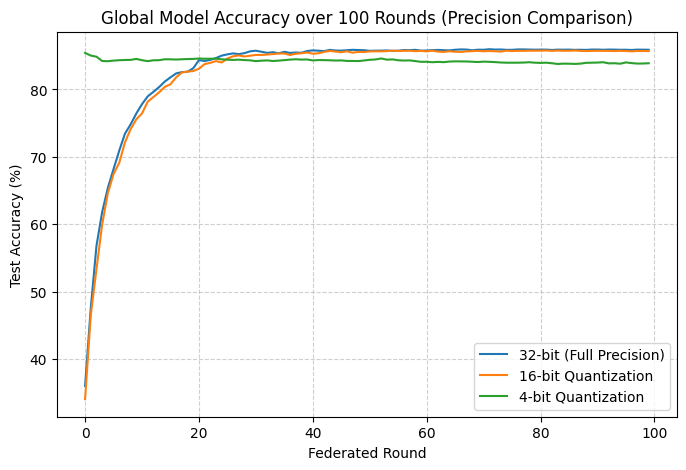

In [15]:
# --- Extract 32-bit accuracies from log string ---
acc_32 = [float(x) for x in re.findall(r"Test Acc:\s*([\d\.]+)", log_text_32)]

# --- 16-bit and 4-bit accuracies are already lists ---
acc_16 = log_acc_16
acc_4 = log_acc_4

# --- Plot all three curves ---
plt.figure(figsize=(8,5))
plt.plot(acc_32, label="32-bit (Full Precision)")
plt.plot(acc_16, label="16-bit Quantization")
plt.plot(acc_4,  label="4-bit Quantization")

plt.xlabel("Federated Round")
plt.ylabel("Test Accuracy (%)")
plt.title("Global Model Accuracy over 100 Rounds (Precision Comparison)")
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.show()


The 32-bit and 16-bit models perform almost identically, both reaching around 85–88% accuracy after about 20 rounds and stabilizing thereafter. This indicates that 16-bit quantization maintains nearly full precision performance. In contrast, the 4-bit quantized model shows a slight but consistent drop, plateauing near 83–84%, suggesting some information loss due to extreme quantization. Overall, reducing precision to 16 bits has minimal accuracy impact, while 4-bit quantization introduces a small but noticeable degradation.

---

### **4. Gradient Inversion Attacks to Federated Learning**

In this part, you will explore gradient inversion attacks which may break privacy in federated learning. In federated learning, each client receives the current global weights of the network and sends weights updates (gradients) based on local data. But how secure is sharing weights gradients? The [Deep Leakage](https://arxiv.org/pdf/1906.08935.pdf) paper shows it is possible to recover data given weights gradients.
To perform the attack, Deep Leakage first randomly generates a pair of "dummy" inputs and labels and then performs the usual forward and backwards computation.
After deriving the dummy gradients from the dummy data, instead of optimizing model weights as in typical training, Deep Leakage optimizes the dummy inputs and labels to minimize the distance between dummy gradients and real gradients. You may refer to the paper for more details.

In [ ]:
## Code Cell 4.1
dst = torchvision.datasets.CIFAR100("./data", download=True)
tp = transforms.Compose([
    transforms.Resize(32),
    transforms.CenterCrop(32),
    transforms.ToTensor()
])
tt = transforms.ToPILImage()

device = "cpu"
if torch.cuda.is_available():
    device = "cuda"
print("Running on %s" % device)

def label_to_onehot(target, num_classes=100):
    target = torch.unsqueeze(target, 1)
    onehot_target = torch.zeros(target.size(0), num_classes, device=target.device)
    onehot_target.scatter_(1, target, 1)
    return onehot_target

def cross_entropy_for_onehot(pred, target):
    return torch.mean(torch.sum(- target * F.log_softmax(pred, dim=-1), 1))


def weights_init(m):
    if hasattr(m, "weight"):
        m.weight.data.uniform_(-0.5, 0.5)
    if hasattr(m, "bias"):
        m.bias.data.uniform_(-0.5, 0.5)

class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        act = nn.Sigmoid
        self.body = nn.Sequential(
            nn.Conv2d(3, 12, kernel_size=5, padding=5//2, stride=2),
            act(),
            nn.Conv2d(12, 12, kernel_size=5, padding=5//2, stride=2),
            act(),
            nn.Conv2d(12, 12, kernel_size=5, padding=5//2, stride=1),
            act(),
            nn.Conv2d(12, 12, kernel_size=5, padding=5//2, stride=1),
            act(),
        )
        self.fc = nn.Sequential(
            nn.Linear(768, 100)
        )

    def forward(self, x):
        out = self.body(x)
        out = out.view(out.size(0), -1)
        # print(out.size())
        out = self.fc(out)
        return out

net = LeNet().to(device)

net.apply(weights_init)
criterion = cross_entropy_for_onehot

######### one client #########
img_index = 25
gt_data = tp(dst[img_index][0]).to(device)
gt_data = gt_data.view(1, *gt_data.size())
gt_label = torch.Tensor([dst[img_index][1]]).long().to(device)
gt_label = gt_label.view(1, )
gt_onehot_label = label_to_onehot(gt_label, num_classes=100)

plt.imshow(tt(gt_data[0].cpu()))
plt.title("Ground truth image")
print("GT label is %d." % gt_label.item(), "\nOnehot label is %d." % torch.argmax(gt_onehot_label, dim=-1).item())

# compute original gradient
out = net(gt_data)
y = criterion(out, gt_onehot_label)
dy_dx = torch.autograd.grad(y, net.parameters())


# share the gradients with the server
original_dy_dx = list((_.detach().clone() for _ in dy_dx))


def defense_method(dy_dx, defense_strategy):

  if defense_strategy=='none':
    # no defense
    return dy_dx

  elif defense_strategy=='pruning':
    # PART 4.1: pruning
    return ...

  elif defense_strategy=='quantization':
    # PART 4.1: quantization
    return ...

  elif defense_strategy=='noise':
    # PART 4.1: noise injection
    return ...


original_dy_dx = defense_method(original_dy_dx, your_defense)

######### Start attack ##########

# generate dummy data and label
dummy_data = torch.randn(gt_data.size()).to(device).requires_grad_(True)
dummy_label = torch.randn(gt_onehot_label.size()).to(device).requires_grad_(True)

plt.imshow(tt(dummy_data[0].cpu()))
plt.title("Dummy data")
print("Dummy label is %d." % torch.argmax(dummy_label, dim=-1).item())

optimizer = torch.optim.LBFGS([dummy_data, dummy_label] )

history = []
for iters in range(300):
    def closure():
        optimizer.zero_grad()

        pred = net(dummy_data)
        dummy_onehot_label = F.softmax(dummy_label, dim=-1)
        dummy_loss = criterion(pred, dummy_onehot_label) # TODO: fix the gt_label to dummy_label
        dummy_dy_dx = torch.autograd.grad(dummy_loss, net.parameters(), create_graph=True)

        grad_diff = 0
        grad_count = 0
        for gx, gy in zip(dummy_dy_dx, original_dy_dx): # TODO: fix the variables here
            grad_diff += ((gx - gy) ** 2).sum()
            grad_count += gx.nelement()
        # grad_diff = grad_diff / grad_count * 1000
        grad_diff.backward()

        return grad_diff

    optimizer.step(closure)
    if iters % 10 == 0:
        current_loss = closure()
        print(iters, "%.4f" % current_loss.item())
    history.append(tt(dummy_data[0].cpu()))



In [ ]:
## Code Cell 4.2
plt.figure(figsize=(12, 8))
for i in range(30):
  plt.subplot(3, 10, i + 1)
  plt.imshow(history[i * 10])
  plt.title("iter=%d" % (i * 10))
  plt.axis('off')
print("Dummy label is %d." % torch.argmax(dummy_label, dim=-1).item())

<font color='red'>**PART 4.1:**</font> [15 points]

In this part, we conduct a gradient inversion attack on a ConvNet model and implement several defense strategies. You will run experiments under 4 different settings:
1. Baseline: original Deep Leakage without any defenses (we have provided this code in *Code Cell 4.1*)
2. Noise: defend against the attack by injecting Gaussian noise  $𝒩(0, 10^{-3})$ to the weights gradients
3. Pruning: defend against the attack by pruning gradients: use unstructured magnitude pruning to set 20% of the gradient values to zero.
4. Quantization: defend against the attack by performing 4-bit quantization (`nbit=4`) on the gradients with the function you implemented in **PART 3.2**.

<font color='red'>**Deliverables**</font>

1. Implement the three defense strategies (i.e., noise injection, pruning, and quantization) `defense_method` in *Code Cell 4.1*.
2. Run the 4 experiments (i.e., Baseline, Noise, Pruning, and Quantization). For each experiment, you should report: (1) the final inversion result as measured by $\|\text{image}-\text{recovered_image}\|_2$ and (2) the optimization process of inversion using *Code Cell 4.2*.
3. Compare and discuss the effectiveness of the 3 different defense strategies. (100 words maximum)



---

### **5. Fine-Tune a Large Pre-Trained Stable Diffusion Model to Learn a New Concept**

In this part, you will fine-tune Stable Diffusion v1.5 (SD v1.5) so it adapts to a new subject using few images ($\approx 5$). After fine-tuning, the model should generate images that depict your subject when prompted.

#### What you’ll learn

* How to take a large, pre-trained text-to-image model and specialize it to a new concept with few-shot data (5 images).
* The end-to-end workflow: data collection, token selection, fine-tuning, and inference.

#### Workflow

1. **Data Collection.**
   Use *five images of HT* as input. Your goal is to fine-tune SD v1.5 on these few samples so the model learns a concept that is **not present** in the original training data.

2. **Token Selection.**
   Choose a rare identifier token—here we use `sks`—as in *DreamBooth: Fine-Tuning Text-to-Image Diffusion Models for Subject-Driven Generation* (Ruiz et al., 2023).
   You will bind this special token to *HT’s appearance/patterns*, so prompts like
   `a photo of sks person`
   refer to your specific subject.

3. **Fine-Tuning Session (you implement this).**
   Fine-tune *a small set of layers* in the U-Net of SD v1.5 (see *Part 5.1* and *Code Cell: 5.17* ) to adapt the model while using less GPU memory than updating all U-Net layers.

4. **Inference (Generate images with the new concept).**
   After fine-tuning, generate images that include *HT’s pattern* when prompted.


**Installing the Necessary Libraries**

Before running the code in this notebook, make sure you have all the required libraries installed. You can install them using the commands below:


> **⚙️ Code Cell 5.1 — Install Required Libraries**
>
> This cell installs all necessary libraries for the assignment (see **Code Cell: Setup & Prerequisites**).

> - If you **have not** installed them yet, run **Code Cell: Setup & Prerequisites** first.
> - If you **already** ran it, you can **skip** this cell and proceed to the next one.

**Checking GPU Details**

To make sure you're using a GPU and to check its details, you can run the following command:

In [ ]:
## Code Cell 5.2

!nvidia-smi

**Core Library Imports for Model Operations**

Below are the libraries needed for this notebook, along with the specific versions used:

- **PyTorch version:** 2.4.1+cu121
- **Diffusers version:** 0.30.3
- **Transformers version:** 4.44.2
- **Accelerate version**: 0.34.2  


**Computing Resource**

- GPU: 1× NVIDIA Tesla T4 (15,360 MB VRAM)

In [ ]:
## Code Cell 5.3

import torch
import diffusers
import transformers
import accelerate

# Expected versions
expected = {
    "PyTorch": "2.4.1+cu121",
    "Diffusers": "0.30.3",
    "Transformers": "4.44.2",
    "Accelerate": "0.34.2",
}

# Print detected versions
print(f"PyTorch version: {torch.__version__}")
print(f"Diffusers version: {diffusers.__version__}")
print(f"Transformers version: {transformers.__version__}")
print(f"Accelerate version: {accelerate.__version__}")

# Check if they match
if (
    torch.__version__ == expected["PyTorch"]
    and diffusers.__version__ == expected["Diffusers"]
    and transformers.__version__ == expected["Transformers"]
    and accelerate.__version__ == expected["Accelerate"]
):
    print("Passed ✅")
else:
    print("Version mismatch ❌")


In [ ]:
## Code Cell 5.4

import requests
from io import BytesIO
from PIL import Image
import logging
import sys
import re
import math

import bitsandbytes as bnb
from tqdm import tqdm
import itertools

from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np

from transformers import CLIPTextModel, CLIPTokenizer, get_scheduler
from diffusers import (
    AutoencoderKL, UNet2DConditionModel, DDPMScheduler,
    StableDiffusionPipeline, DPMSolverMultistepScheduler)
from accelerate import Accelerator
from accelerate.utils import set_seed

from torchvision import transforms
from torch.utils.data import Dataset
import torch.nn.functional as F

import gc
from diffusers import StableDiffusionPipeline

**Model Selection: Stable Diffusion v1.5**

We have selected **Stable Diffusion v1.5** for its balanced performance in image quality and resource efficiency.
For versions 1.5, the default resolution remains at $512 \times 512$, making them more memory efficient.


In [ ]:
## Code Cell 5.5
pretrained_model_name_or_path = "runwayml/stable-diffusion-v1-5"
resolution = 512

**Data Collection: Training Subject: HT’s images**

Use five images of HT as your training subject. These images will be used to fine-tune SD v1.5.

Run *Code Cell 5.6* to define `urls` list with HT's images (it lists the five image *URLs*).

You will *download and prepare* these images in *Code Cell 5.7*, saving them to `data/assets/` before fine-tuning.


In [ ]:
## Code Cell 5.6

urls = [
      "https://drive.google.com/file/d/1T2ikMo95TEi0jjtA_eDQhUzVMZgueGbD/view?usp=sharing",
      "https://drive.google.com/file/d/1W2oczGxst7NzzzTMn4RL3xHRKE0GfZ6E/view?usp=sharing",
      "https://drive.google.com/file/d/1UTG1lKVchRRCciVJQh0Gi-8XrsVhGJet/view?usp=sharing",
      "https://drive.google.com/file/d/1s_Gy9Zhs6KSGzrI5J8tKWqyYgTpIhA5o/view?usp=sharing",
      "https://drive.google.com/file/d/1zHdNa7txsoqh08KI2FsWnI8sGLNCjBHg/view?usp=sharing",
]

**🌐 Download Images from a URL**

Downloads an image from a URL and converts it to RGB format.

In [ ]:
## Code Cell 5.7
def _extract_gdrive_file_id(url: str) -> str | None:
    # Matches: /file/d/<ID>/view ... or ... open?id=<ID>
    m = re.search(r"/file/d/([a-zA-Z0-9_-]+)", url)
    if m:
        return m.group(1)
    m = re.search(r"[?&]id=([a-zA-Z0-9_-]+)", url)
    if m:
        return m.group(1)
    return None

def download_image(url: str, timeout: int = 10):
    file_id = _extract_gdrive_file_id(url)
    if not file_id:
        print("Error: could not parse Google Drive file id from URL.")
        return None

    session = requests.Session()
    base = "https://drive.google.com/uc?export=download&id=" + file_id

    try:
        r = session.get(base, timeout=timeout, stream=True)
        r.raise_for_status()

        if "text/html" in r.headers.get("Content-Type", "").lower():
            m = re.search(r'confirm=([0-9A-Za-z_-]+)', r.text)
            if m:
                confirm = m.group(1)
                r = session.get(base + f"&confirm={confirm}", timeout=timeout, stream=True)
                r.raise_for_status()

        # Load image from bytes
        data = r.content if not hasattr(r, "raw") else r.content
        img = Image.open(BytesIO(data)).convert("RGB")
        return img

    except requests.exceptions.RequestException as e:
        print(f"Error downloading image: {e}")
    except (Image.UnidentifiedImageError, OSError) as e:
        print(f"Error processing image: {e}")

    return None

**Visualization Function to Display Images**

This function, `image_grid`, shows images in a grid using `matplotlib`:

- **Inputs**:
  - `images`: List of images to display.
  - `rows`: Number of rows in the grid.
  - `cols`: Number of columns in the grid.

In [ ]:
## Code Cell 5.8

def image_grid(images: list, rows: int = 1, cols: int = 2):
    fig, axes = plt.subplots(rows, cols, figsize=(5 * cols, 5 * rows))

    if not isinstance(axes, np.ndarray):
        axes = np.array([axes])
    axes = axes.ravel()

    nslots = rows * cols
    for i in range(nslots):
        ax = axes[i]
        if i < len(images):
            ax.imshow(images[i])
            ax.axis("off")
        else:
            ax.axis("off")

    plt.tight_layout()
    plt.show()

**Save Images to the `assets/` Folder**

Saves images to the `assets/` folder using the `download_image` function.

In [ ]:
## Code Cell 5.9

from pathlib import Path
from PIL import Image
import os

# Where images will be saved (downloaded/prepared in Code Cell 5.7)
subject_assets_path = Path("./assets/")
subject_assets_path.mkdir(parents=True, exist_ok=True)  # Create folder if not exists

# Download images: 'urls' is already defined in Code Cell 5.6
subject_images = [image for url in urls if (image := download_image(url)) is not None]
for idx, img in enumerate(subject_images):
    img.save(subject_assets_path.joinpath(f"{idx}.jpeg")) # Save each image

# Quick visual check
image_grid(subject_images, rows=1, cols=len(subject_images))
print(f"Saved {len(subject_images)} images to {subject_assets_path.resolve()}")

**The Logging Function**

Records messages during code execution.

In [ ]:
## Code Cell 5.10

def get_logger(name, log_file=None, level=logging.DEBUG):
    # Create a custom logger
    logger = logging.getLogger(name)

    # Set the default logging level
    logger.setLevel(level)

    # Create a handler for output to the console (stdout)
    console_handler = logging.StreamHandler(sys.stdout)
    console_handler.setLevel(level)

    # Create a formatter and set it for the handler
    formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
    console_handler.setFormatter(formatter)

    # Add the console handler to the logger
    logger.addHandler(console_handler)

    # Optional: Log to a file if log_file is provided
    if log_file:
        file_handler = logging.FileHandler(log_file)
        file_handler.setLevel(level)
        file_handler.setFormatter(formatter)
        logger.addHandler(file_handler)

    return logger

**Create the DataLoader**

Creates a DataLoader that reads the specific subject images (your training assets) and the regularization set used to preserve the model’s general visual knowledge while adapting to the new subject.

In [ ]:
## Code Cell 5.11

class DreamBoothDataset(Dataset):
    def __init__(
        self,
        instance_data_root,
        instance_prompt,
        tokenizer,
        class_data_root=None,
        class_prompt=None,
        size=512,
        center_crop=False,
    ):
        self.size = size
        self.center_crop = center_crop
        self.tokenizer = tokenizer

        self.instance_data_root = Path(instance_data_root)
        if not self.instance_data_root.exists():
            raise ValueError("Instance images root doesn't exists.")

        self.instance_images_path = list(Path(instance_data_root).iterdir())
        self.num_instance_images = len(self.instance_images_path)
        self.instance_prompt = instance_prompt
        self._length = self.num_instance_images

        if class_data_root is not None:
            self.class_data_root = Path(class_data_root)
            self.class_data_root.mkdir(parents=True, exist_ok=True)
            self.class_images_path = list(Path(class_data_root).iterdir())
            self.num_class_images = len(self.class_images_path)
            self._length = max(self.num_class_images, self.num_instance_images)
            self.class_prompt = class_prompt
        else:
            self.class_data_root = None

        self.image_transforms = transforms.Compose(
            [
                transforms.Resize(size, interpolation=transforms.InterpolationMode.BILINEAR),
                transforms.CenterCrop(size) if center_crop else transforms.RandomCrop(size),
                transforms.ToTensor(),
                transforms.Normalize([0.5], [0.5]),
            ]
        )

    def __len__(self):
        return self._length

    def __getitem__(self, index):
        example = {}
        instance_image = Image.open(self.instance_images_path[index % self.num_instance_images])
        if not instance_image.mode == "RGB":
            instance_image = instance_image.convert("RGB")
        example["instance_images"] = self.image_transforms(instance_image)
        example["instance_prompt_ids"] = self.tokenizer(
            self.instance_prompt,
            padding="do_not_pad",
            truncation=True,
            max_length=self.tokenizer.model_max_length,
        ).input_ids

        if self.class_data_root:
            class_image = Image.open(self.class_images_path[index % self.num_class_images])
            if not class_image.mode == "RGB":
                class_image = class_image.convert("RGB")
            example["class_images"] = self.image_transforms(class_image)
            example["class_prompt_ids"] = self.tokenizer(
                self.class_prompt,
                padding="do_not_pad",
                truncation=True,
                max_length=self.tokenizer.model_max_length,
            ).input_ids

        return example


class PromptDataset(Dataset):
    def __init__(self, prompt, num_samples):
        self.prompt = prompt
        self.num_samples = num_samples

    def __len__(self):
        return self.num_samples

    def __getitem__(self, index):
        example = {}
        example["prompt"] = self.prompt
        example["index"] = index
        return example

**Collate Function for DataLoader**

This function prepares each training batch by combining instance prompts and their corresponding images. It can also include additional class prompts and images to help the model maintain its general visual knowledge while learning the new subject.

In [ ]:
## Code Cell 5.12

def collate_fn(examples, tokenizer, with_prior_preservation: bool=False):
    input_ids = [example["instance_prompt_ids"] for example in examples]
    pixel_values = [example["instance_images"] for example in examples]

    # Combine class and instance examples for prior preservation
    if with_prior_preservation:
        input_ids += [example["class_prompt_ids"] for example in examples]
        pixel_values += [example["class_images"] for example in examples]

    pixel_values = torch.stack(pixel_values)
    pixel_values = pixel_values.to(memory_format=torch.contiguous_format).float()

    input_ids = tokenizer.pad(
        {"input_ids": input_ids},
        padding="max_length",
        return_tensors="pt",
        max_length=tokenizer.model_max_length
    ).input_ids

    batch = {
        "input_ids": input_ids,
        "pixel_values": pixel_values,
    }
    return batch

**Fine-Tuning Stable Diffusion Settings**

These are the settings for **Fine-tuning Stable Diffusion (SD)**.

- The **special token** (e.g., `sks`) is rarely used by the text encoder, so we update its embedding to "memorize" the patterns of your input images.

- **with_prior_preservation = True** helps prevent overfitting, ensuring the fine-tuned SD model can still generate generic objects (e.g., a generic person) in addition to your specific subject (e.g., HT’s appearance).

- **num_class_images = 20** specifies that 20 generic reference images (e.g., generic person) are used alongside your subject images during fine-tuning.

- **max_train_steps = 400** sets the training to 400 steps.

In [ ]:
## Code Cell 5.13

# The special token that is rarely used by the text encoder.
# We replace this token’s embedding to "memorize" the patterns of your personal images.
# For example, if you describe "person", Stable Diffusion will generate a generic person.
# But if you say "sks person", it will generate an image of your specific person pictures.
special_token = "sks"

# The name of the object related to your specific-subject images.
object_name = "person"

# The prompt to describe your specific subject images.
# A basic example: "a photo of [special_token] [object_name]".
instance_prompt = f"a photo of {special_token} {object_name}"

# The directory where checkpoints and other outputs will be saved.
output_dir = "logs"

# If `with_prior_preservation` is set to True, we create a regularization set to avoid overfitting.
with_prior_preservation = True

# The weight assigned to the prior preservation loss.
prior_loss_weight = 0.5

# Folder containing class images for prior preservation.
prior_preservation_class_folder = "class_images"

# The prompt used to generate class images for regularization.
prior_preservation_class_prompt = f"a photo of {object_name}"

# Minimum number of class images required for prior preservation .
num_class_images = 20

# We set a lower number of training steps for this assignment.
max_train_steps = 400

# Interval (in steps) at which checkpoints are saved.
checkpointing_steps = 200

# Random seed for reproducibility.
seed = 42

# Set batch size. If prior preservation is disabled, use batch size of 2; otherwise, set it to 1.
train_batch_size = 2 if not with_prior_preservation else 1

# Learning rate for the training process.
learning_rate = 5e-06

class Arguments:
    def __init__(self):
        self.pretrained_model_name_or_path = pretrained_model_name_or_path  # (str) Path to the pretrained model
        self.resolution = resolution  # (int) Input resolution for images (default: 512)
        self.instance_data_dir = subject_assets_path  # (str) Directory containing instance images
        self.instance_prompt = instance_prompt  # (str) Template for generating prompts related to instance images
        self.learning_rate = learning_rate  # (float) Learning rate for training
        self.max_train_steps = max_train_steps  # (int) Maximum number of training steps
        self.checkpointing_steps = checkpointing_steps  # (int) Interval (in steps) for saving checkpoints
        self.output_dir = output_dir  # (str) Directory to save checkpoints and output files
        self.train_batch_size = train_batch_size  # (int) Number of samples per batch for training
        self.seed = seed  # (int) Seed for random number generation to ensure reproducibility

        self.mixed_precision = "fp16"  # (str) Use mixed precision (default: "fp16"); choose between "fp16" and "bf16"
        self.gradient_checkpointing = True  # (bool) Use gradient checkpointing to reduce memory usage (default: True)
        self.use_8bit_adam = True  # (bool) Use the 8-bit Adam optimizer for lower memory usage (default: True)

        self.center_crop = True  # (bool) Whether to apply center cropping to images (default: True)
        self.train_text_encoder = False  # (bool) Whether to train the text encoder (default: False)
        self.gradient_accumulation_steps = 2  # (int) Steps to accumulate gradients before backpropagation (default: 2)
        self.max_grad_norm = 1.0  # (float) Maximum value for gradient clipping (default: 1.0)
        self.with_prior_preservation = with_prior_preservation  # (bool) Whether to apply prior preservation loss (default: False)
        self.prior_loss_weight = prior_loss_weight  # (float) Weight for prior preservation loss if enabled (default: 0.5)
        self.class_data_dir = prior_preservation_class_folder if with_prior_preservation else None  # (str or None) Directory for class images, used in prior preservation
        self.class_prompt = prior_preservation_class_prompt if with_prior_preservation else ""  # (str) Prompt for class images if using prior preservation
        self.num_class_images = num_class_images  # (int) Minimum number of class images needed for prior preservation
        self.lr_warmup_steps = 100  # (int) Number of warmup steps for the learning rate scheduler (default: 100)
        self.lr_scheduler = "constant"  # (str) Type of learning rate scheduler (default: "constant")

# Create an instance of Arguments to use
args = Arguments()


**Create Folder for Saving Checkpoints**

Creates the directory specified in `args.output_dir` to save checkpoints. If the folder doesn't exist, it will be automatically created.

In [ ]:
## Code Cell 5.14
Path(args.output_dir).mkdir(parents=True, exist_ok=True)

**Create a Regularization Set for the Specified Class**

The following code creates a regularization set for the given `object_name` and saves the images to `class_data_dir`.
A **regularization set** is a small set of generic class images used during fine-tuning to preserve the model’s general knowledge and reduce overfitting.

In [ ]:
## Code Cell 5.15

sample_batch_size = 2
if args.with_prior_preservation:
    class_images_dir = Path(args.class_data_dir)
    class_images_dir.mkdir(parents=True, exist_ok=True)
    cur_class_images = len(list(class_images_dir.iterdir()))

    if cur_class_images < args.num_class_images:
        pipeline = StableDiffusionPipeline.from_pretrained(pretrained_model_name_or_path, torch_dtype=torch.float16, safety_checker=None).to("cuda")
        pipeline.set_progress_bar_config(disable=True)

        num_new_images = num_class_images - cur_class_images
        print(f"Number of class images to sample: {num_new_images}.")

        sample_dataset = PromptDataset(args.class_prompt, num_new_images)
        sample_dataloader = torch.utils.data.DataLoader(sample_dataset, batch_size=sample_batch_size)

        for example in tqdm(sample_dataloader, desc="Generating class images"):
            with torch.autocast("cuda"):
                images = pipeline(example["prompt"]).images

            for i, image in enumerate(images):
                image.save(class_images_dir / f"{example['index'][i] + cur_class_images}.jpg")
        pipeline = None
        gc.collect()
        del pipeline
        with torch.no_grad():
          torch.cuda.empty_cache()

**Print Parameter Count**

This function displays the total and trainable number of parameters in the model.

In [ ]:
## Code Cell 5.16

def print_params(model):
    total = 0
    trainable = 0
    for name, p in model.named_parameters():
        n = p.numel()
        total += n
        if p.requires_grad:
            trainable += n
    pct = (trainable / total * 100) if total else 0.0
    def to_m(x):  # millions
        return f"{x/1e6:.2f}M"

    print("-" * 80)
    print(f"Total: {to_m(total)} | Trainable: {to_m(trainable)} ({pct:.2f}%)")

**Function for Fine-Tuning Stable Diffusion**

<font color='red'>**PART 5.1:**</font> [15 points]

In this section, you will fine-tune a small subset of layers in the U-Net of Stable Diffusion v1.5.

<font color='red'>**Deliverables**</font>

- Unfreeze the Q, K, V projections and the `to_out` layer in all attention blocks of the U-Net.
- Set these parameters to require gradient updates during fine-tuning and append them to the `trainable_params` list.
- Keep all other U-Net parameters frozen.
- Also report the number of *tunable parameters* from your implementation (use the value printed by `print_params()`) in **Part 5.1** of your Overleaf project.


In [ ]:
## Code Cell 5.17

def finetune_sd(collate_fn):
    logger = get_logger(__name__)

    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()  # Clear the GPU memory cache

    # Load models and create wrapper for stable diffusion
    text_encoder = CLIPTextModel.from_pretrained(
        pretrained_model_name_or_path,
        subfolder="text_encoder"
    )
    vae = AutoencoderKL.from_pretrained(
        pretrained_model_name_or_path,
        subfolder="vae"
    )
    unet = UNet2DConditionModel.from_pretrained(
        pretrained_model_name_or_path,
        subfolder="unet"
    )
    tokenizer = CLIPTokenizer.from_pretrained(
        pretrained_model_name_or_path,
        subfolder="tokenizer",
    )

    set_seed(args.seed)

    accelerator = Accelerator(
        gradient_accumulation_steps=args.gradient_accumulation_steps,
        mixed_precision=args.mixed_precision,
    )

    if args.train_text_encoder and args.gradient_accumulation_steps > 1 and accelerator.num_processes > 1:
        raise ValueError(
            "Gradient accumulation is not supported when training the text encoder in distributed training. "
            "Please set gradient_accumulation_steps to 1. This feature will be supported in the future."
        )

    vae.requires_grad_(False)
    if not args.train_text_encoder:
        text_encoder.requires_grad_(False)

    if args.gradient_checkpointing:
        unet.enable_gradient_checkpointing()
        if args.train_text_encoder:
            text_encoder.gradient_checkpointing_enable()

    # Use 8-bit Adam for lower memory usage or to fine-tune the model in 16GB GPUs
    if args.use_8bit_adam:
        optimizer_class = bnb.optim.AdamW8bit
    else:
        optimizer_class = torch.optim.AdamW

    # ======================= IMPLEMENT HERE (START) =======================
    # Freeze everything in UNet
    for p in unet.parameters():
        p.requires_grad = False

    # Unfreeze (enable training) for specific attention-related layers: Q, K, V, and to_out layers
    trainable_params = []
    for name, p in unet.named_parameters():
        # PART 5.1: Implement!

    # ======================= IMPLEMENT HERE (END) =========================

    print_params(unet)

    optimizer = optimizer_class(
        trainable_params,
        lr=args.learning_rate,
    )

    noise_scheduler = DDPMScheduler.from_config(args.pretrained_model_name_or_path, subfolder="scheduler")

    train_dataset = DreamBoothDataset(
        instance_data_root=args.instance_data_dir,
        instance_prompt=args.instance_prompt,
        class_data_root=args.class_data_dir if args.with_prior_preservation else None,
        class_prompt=args.class_prompt,
        tokenizer=tokenizer,
        size=args.resolution,
        center_crop=args.center_crop,
    )

    train_dataloader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=args.train_batch_size,
        shuffle=True,
        collate_fn=lambda examples: collate_fn(examples, tokenizer, args.with_prior_preservation),
    )

    lr_scheduler = get_scheduler(
        args.lr_scheduler,
        optimizer=optimizer,
        num_warmup_steps=args.lr_warmup_steps * args.gradient_accumulation_steps,
        num_training_steps=args.max_train_steps * args.gradient_accumulation_steps,
    )

    unet, optimizer, train_dataloader, lr_scheduler = accelerator.prepare(
        unet, optimizer, train_dataloader, lr_scheduler
    )

    weight_dtype = torch.float32
    if accelerator.mixed_precision == "fp16":
        weight_dtype = torch.float16
    elif accelerator.mixed_precision == "bf16":
        weight_dtype = torch.bfloat16

    vae.to(accelerator.device, dtype=weight_dtype)
    vae.decoder.to("cpu")

    if not args.train_text_encoder:
        text_encoder.to(accelerator.device, dtype=weight_dtype)

    # We need to recalculate our total training steps as the size of the training dataloader may have changed.
    num_update_steps_per_epoch = math.ceil(len(train_dataloader) / args.gradient_accumulation_steps)
    num_train_epochs = math.ceil(args.max_train_steps / num_update_steps_per_epoch)

    total_batch_size = args.train_batch_size * accelerator.num_processes * args.gradient_accumulation_steps

    logger.info("***** Running training *****")
    logger.info(f"  Num examples = {len(train_dataset)}")
    logger.info(f"  Instantaneous batch size per device = {args.train_batch_size}")
    logger.info(f"  Total train batch size (w. parallel, distributed & accumulation) = {total_batch_size}")
    logger.info(f"  Gradient Accumulation steps = {args.gradient_accumulation_steps}")
    logger.info(f"  Total optimization steps = {args.max_train_steps}")

    # Only show the progress bar once on each machine.
    progress_bar = tqdm(range(args.max_train_steps), disable=not accelerator.is_local_main_process)
    progress_bar.set_description("Steps")
    global_step = 0

    for epoch in range(num_train_epochs):
        unet.train()
        for step, batch in enumerate(train_dataloader):
            with accelerator.accumulate(unet):

                # 1. Transform images to latent space
                src_imgs = batch["pixel_values"].to(dtype=weight_dtype) # Get images
                latents = vae.encode(src_imgs).latent_dist.sample() # Extract the latent distribution
                latents = latents * 0.18215 # Scale the latents

                # 2. Generate noise to be added to the latents
                noise = torch.randn_like(latents) # Create random noise
                batch_size, channels, height, width = latents.shape

                # 3. Select a random timestep for each image
                timesteps = torch.randint(
                    0, noise_scheduler.config.num_train_timesteps,
                    (batch_size,),
                    device=latents.device)
                timesteps = timesteps.long()

                # 4. Add noise to the latents based on the noise level at each timestep
                noisy_latents = noise_scheduler.add_noise(latents, noise, timesteps)

                # 5. Retrieve the text embedding as a condition
                encoder_hidden_states = text_encoder(batch["input_ids"])[0]

                # 6. Predict the noise residual
                model_pred = unet(noisy_latents, timesteps, encoder_hidden_states).sample

                # Get the target for loss depending on the prediction type
                if noise_scheduler.config.prediction_type == "epsilon":
                    target = noise
                elif noise_scheduler.config.prediction_type == "v_prediction":
                    target = noise_scheduler.get_velocity(latents, noise, timesteps)
                else:
                    raise ValueError(f"Unknown prediction type {noise_scheduler.config.prediction_type}")

                if args.with_prior_preservation:
                    # Chunk the noise and model_pred into two parts and compute the loss on each part separately.
                    model_pred, model_pred_prior = torch.chunk(model_pred, 2, dim=0)
                    target, target_prior = torch.chunk(target, 2, dim=0)

                    # 7-1. Compute instance loss
                    loss = F.mse_loss(model_pred.float(), target.float(), reduction="none").mean([1, 2, 3]).mean()

                    # 7-2. Compute prior loss
                    prior_loss = F.mse_loss(model_pred_prior.float(), target_prior.float(), reduction="mean")

                    # 7-3. Add the prior loss to the instance loss
                    loss = loss + args.prior_loss_weight * prior_loss
                else:
                    # 7. Compute instance loss
                    loss = F.mse_loss(model_pred.float(), target.float(), reduction="mean")

                accelerator.backward(loss)

                if accelerator.sync_gradients:
                    accelerator.clip_grad_norm_(trainable_params, args.max_grad_norm)

                optimizer.step()
                lr_scheduler.step()
                optimizer.zero_grad()

            # Checks if the accelerator has performed an optimization step behind the scenes
            if accelerator.sync_gradients:
                progress_bar.update(1)
                global_step += 1

                if global_step % args.checkpointing_steps == 0:
                    if accelerator.is_main_process:

                        save_unet_path = Path(args.output_dir).joinpath(f"unet_checkpoint-{global_step}.pth")
                        torch.save(unet.state_dict(), save_unet_path)

            # logs = {"loss": loss.detach().item()}
            logs = {"loss": loss.detach().item(), "lr": lr_scheduler.get_last_lr()[0]}
            progress_bar.set_postfix(**logs)

            if global_step >= args.max_train_steps:
                break

        accelerator.wait_for_everyone()

    # Create the pipeline using using the trained modules and save it.
    if accelerator.is_main_process:

        save_unet_path = Path(args.output_dir).joinpath(f"unet_checkpoint-{global_step}.pth")
        torch.save(unet.state_dict(), save_unet_path)


**Start Fine-Tuning with `Accelerate`**

This command starts running the `finetune_sd` function using `Accelerate`.

In [ ]:
## Code Cell 5.18

accelerate.notebook_launcher(finetune_sd, args=(collate_fn,))

**Clear Cache and Collect Garbage for Memory Management**

In [ ]:
## Code Cell 5.19

# Before clearing cache and collecting garbage, run nvidia-smi to check current GPU memory usage.
!nvidia-smi

# Clear GPU and CPU caches
gc.collect()
torch.cuda.empty_cache()

# After clearing, run nvidia-smi again to confirm that unused memory has been released.
!nvidia-smi
print("✅ Cache cleared and garbage collected.")

**Load Pre-trained Stable Diffusion and Fine-tuned UNet Weights**

This step loads the pre-trained Stable Diffusion model and the fine-tuned UNet weights for later inference.

In [ ]:
## Code Cell 5.20

unet_checkpoint_name = "unet_checkpoint-400.pth"
save_unet_weight_path = os.path.join(args.output_dir, unet_checkpoint_name)

pipe = StableDiffusionPipeline.from_pretrained(
    args.pretrained_model_name_or_path,
    torch_dtype=torch.float16,
).to("cuda")

unet_state_dict = torch.load(save_unet_weight_path)

print(list(unet_state_dict.keys()))
msg = pipe.unet.load_state_dict(unet_state_dict, strict=False)
print(msg)

pipe.scheduler = DPMSolverMultistepScheduler.from_config(pipe.scheduler.config)

# Now the pipeline will use the DPMSolverMultistepScheduler
print(f"Scheduler has been updated to: {type(pipe.scheduler)}")



<font color='red'>**PART 5.2:**</font> [10 points]

Generate images using the fine-tuned Stable Diffusion model.

<font color='red'>**Deliverables**</font>

From *Code Cell 5.23* to *Code Cell 5.30*, generate comparison images **with** the `sks` token and **without** it using the provided prompts.  
Then include those images in **Figure 1** of your Overleaf project by replacing each placeholder with the corresponding image you generated.


**Generate Unique Images of the Specific Subject (HT)**

Let’s create new images that reflect HT’s appearance and visual patterns using the fine-tuned SD v1.5 model.

In [ ]:
## Code Cell 5.23

# (Example 1: with `sks` token) Define the text prompt for image generation using the special identifier token `sks`.
prompt = "a photo of sks person next to the lake"
negative_prompt = "jpeg artifact, lowres"

num_inference_steps = 100
guidance_scale = 7.5

num_images_per_prompt = 1
num_rows = 1

seed = 0
generator = torch.Generator().manual_seed(seed)

generated_images = pipe(
         prompt,
         negative_prompt=negative_prompt,
         num_images_per_prompt=num_images_per_prompt,
         num_inference_steps=num_inference_steps,
         guidance_scale=guidance_scale,
         generator=generator).images

grid = image_grid(generated_images, rows=1, cols=num_images_per_prompt)
grid

In [ ]:
## Code Cell 5.24

# (Example 1: without `sks` token) Define the text prompt for image generation using the special identifier token `sks`.
prompt = "a photo of person next to the lake"
negative_prompt = "jpeg artifact, lowres"

num_inference_steps = 100
guidance_scale = 7.5

num_images_per_prompt = 1
num_rows = 1

seed = 0
generator = torch.Generator().manual_seed(seed)

generated_images = pipe(
         prompt,
         negative_prompt=negative_prompt,
         num_images_per_prompt=num_images_per_prompt,
         num_inference_steps=num_inference_steps,
         guidance_scale=guidance_scale,
         generator=generator).images

grid = image_grid(generated_images, rows=1, cols=num_images_per_prompt)
grid

In [ ]:
## Code Cell 5.25

# (Example 2: with `sks` token) Define the text prompt for image generation using the special identifier token `sks`.
prompt = "a photo of sks person in the office"
negative_prompt = "low quality, lowres, jpeg artifacts"


num_inference_steps = 100
guidance_scale = 7.5

num_images_per_prompt = 1
num_rows = 1

seed = 0
generator = torch.Generator().manual_seed(seed)

generated_images = pipe(
         prompt,
         negative_prompt=negative_prompt,
         num_images_per_prompt=num_images_per_prompt,
         num_inference_steps=num_inference_steps,
         guidance_scale=guidance_scale,
         generator=generator).images

grid = image_grid(generated_images, rows=1, cols=num_images_per_prompt)
grid

In [ ]:
## Code Cell 5.26

# (Example 2: without `sks` token) Define the text prompt for image generation using the special identifier token `sks`.
prompt = "a photo of person in the office"
negative_prompt = "low quality, lowres, jpeg artifacts"


num_inference_steps = 100
guidance_scale = 7.5

num_images_per_prompt = 1
num_rows = 1

seed = 0
generator = torch.Generator().manual_seed(seed)

generated_images = pipe(
         prompt,
         negative_prompt=negative_prompt,
         num_images_per_prompt=num_images_per_prompt,
         num_inference_steps=num_inference_steps,
         guidance_scale=guidance_scale,
         generator=generator).images

grid = image_grid(generated_images, rows=1, cols=num_images_per_prompt)
grid

In [ ]:
## Code Cell 5.27

# (Example 3: with `sks` token) Define the text prompt for image generation using the special identifier token `sks`.
prompt = "a photo of sks person at cafe"


num_inference_steps = 100
guidance_scale = 7.5

num_images_per_prompt = 1
num_rows = 1

seed = 0
generator = torch.Generator().manual_seed(seed)

generated_images = pipe(
         prompt,
         num_images_per_prompt=num_images_per_prompt,
         num_inference_steps=num_inference_steps,
         guidance_scale=guidance_scale,
         generator=generator).images

grid = image_grid(generated_images, rows=1, cols=num_images_per_prompt)
grid

In [ ]:
## Code Cell 5.28

# (Example 3: without `sks` token) Define the text prompt for image generation using the special identifier token `sks`.
prompt = "a photo of person at cafe"


num_inference_steps = 100
guidance_scale = 7.5

num_images_per_prompt = 1
num_rows = 1

seed = 0
generator = torch.Generator().manual_seed(seed)

generated_images = pipe(
         prompt,
         num_images_per_prompt=num_images_per_prompt,
         num_inference_steps=num_inference_steps,
         guidance_scale=guidance_scale,
         generator=generator).images

grid = image_grid(generated_images, rows=1, cols=num_images_per_prompt)
grid

In [ ]:
## Code Cell 5.29

# (Example 4: with `sks` token) Define the text prompt for image generation using the special identifier token `sks`.
prompt = "a photo of sks person on the yard"

num_inference_steps = 100
guidance_scale = 7.5

num_images_per_prompt = 1
num_rows = 1

seed = 0
generator = torch.Generator().manual_seed(seed)

generated_images = pipe(
         prompt,
         num_images_per_prompt=num_images_per_prompt,
         num_inference_steps=num_inference_steps,
         guidance_scale=guidance_scale,
         generator=generator).images

grid = image_grid(generated_images, rows=1, cols=num_images_per_prompt)
grid

In [ ]:
## Code Cell 5.30

# (Example 4: without `sks` token) Define the text prompt for image generation using the special identifier token `sks`.
prompt = "a photo of person on the yard"

num_inference_steps = 100
guidance_scale = 7.5

num_images_per_prompt = 1
num_rows = 1

seed = 0
generator = torch.Generator().manual_seed(seed)

generated_images = pipe(
         prompt,
         num_images_per_prompt=num_images_per_prompt,
         num_inference_steps=num_inference_steps,
         guidance_scale=guidance_scale,
         generator=generator).images

grid = image_grid(generated_images, rows=1, cols=num_images_per_prompt)
grid

---

### **6. Training-Free Multi-Prompt Generation with Varied Resolutions (Inference-Time)**

In Stable Diffusion v1.5, one prompt drives the whole image and the default output is $512 \times 512$. You could enable multi-prompt generation and varied resolutions (e.g., $512 \times 1024$ or $1024 \times 512$) by fine-tuning the model, but that adds training cost and must be repeated for each text-to-image model. In this part, you’ll achieve both at inference time: we’ll slice the latent into regions and guide each region with its own prompt during denoising, while also supporting varied output resolutions. This avoids any re-training, keeps compute to forward passes, and works directly with the pre-trained weights you already have.

You will control different regions of the image with separate text prompts. For example:

- 🔵 The **left/upper partition** of the image is controlled by **<span style="color:#0070C0">text prompt A</span>**.
- 🟢 The **right/lower partition** of the image is controlled by **<span style="color:#50C878">text prompt B</span>**..

<img src="https://drive.google.com/uc?export=view&id=1ZUoVGkQu5CAJkfWcnt2K7Z7bZHaSG8Nc" width="1000"/>



**Installing the Necessary Libraries**

Before running the code in this notebook, make sure you have all the required libraries installed. You can install them using the commands below:


> **⚙️ Code Cell 6.1 — Install Required Libraries**
>
> This cell installs all necessary libraries for the assignment (see **Code Cell: Setup & Prerequisites**).

> - If you **have not** installed them yet, run **Code Cell: Setup & Prerequisites** first.
> - If you **already** ran it, you can **skip** this cell and proceed to the next one.

**Checking GPU Details**

To make sure you're using a GPU and to check its details, you can run the following command:

In [ ]:
## Code Cell 6.2

!nvidia-smi

**Core Library Imports for Model Operations**

Below are the libraries needed for this notebook, along with the specific versions used:

- **PyTorch version:** 2.4.1+cu121
- **Diffusers version:** 0.30.3
- **Transformers version:** 4.44.2
- **xformers version:** 0.0.28


**Computing Resource**

- GPU: 1× NVIDIA Tesla T4 (15,360 MB VRAM)

In [ ]:
## Code Cell 6.3

import torch
import diffusers
import transformers
import accelerate
import xformers

# Expected versions
expected = {
    "PyTorch": "2.4.1+cu121",
    "Diffusers": "0.30.3",
    "Transformers": "4.44.2",
    "Accelerate": "0.34.2",
    "Xformers": "0.0.28",
}

# Print detected versions
print(f"PyTorch version: {torch.__version__}")
print(f"Diffusers version: {diffusers.__version__}")
print(f"Transformers version: {transformers.__version__}")
print(f"Accelerate version: {accelerate.__version__}")
print(f"Xformers version: {xformers.__version__}")

# Check if they match
if (
    torch.__version__ == expected["PyTorch"]
    and diffusers.__version__ == expected["Diffusers"]
    and transformers.__version__ == expected["Transformers"]
    and accelerate.__version__ == expected["Accelerate"]
    and xformers.__version__ == expected["Xformers"]
):
    print("Passed ✅")
else:
    print("Version mismatch ❌")


In [ ]:
## Code Cell 6.4

import PIL
from PIL import Image

from tqdm import tqdm

from transformers import CLIPTextModel, CLIPTokenizer
from diffusers import AutoencoderKL, UNet2DConditionModel, DDIMScheduler

import gc
import random
import numpy as np
from einops import rearrange
from typing import List

import matplotlib.pyplot as plt


**Troubleshooting for Code Cell 6.4**

> <font color='green'>⚠️ NOTE — Only if `AutoencoderKL` import fails when running Code Cell 6.4</font>

>
> If you cannot import `AutoencoderKL` from `diffusers`, follow the steps below.  
>
> If the import works, skip this section and go directly to *Code Cell 6.5*.

If you encounter this error:

```bash
RuntimeError: Failed to import diffusers.models.autoencoders.autoencoder_kl because of the following error (look up to see its traceback):
Failed to import transformers.models.auto.image_processing_auto because of the following error (look up to see its traceback):
partially initialized module 'torchvision' has no attribute 'extension' (most likely due to a circular import)
```

- **Step 1**. Create a new *code cell*  by clicking `+ Code` from the toolbar at the top and paste the following line to Uninstall conflicting packages:
```bash
!pip uninstall -y diffusers torch torchvision torchaudio xformers accelerate
```

- **Step 2.** Reinstall by running Code Cell: Setup & Prerequisites again.

- **Step 3.** After reinstall completes, run *Code Cell 6.4* to import the packages. If imports succeed, proceed to *Code Cell 6.5*.

**Model Selection: Stable Diffusion v1.5**

We have selected **Stable Diffusion v1.5** for its balanced performance in image quality and resource efficiency.


In [ ]:
## Code Cell 6.5

pretrained_model_name_or_path = "runwayml/stable-diffusion-v1-5"

**Memory Efficient Attention using Xformers**

This function implements memory-efficient attention using Xformers for optimized performance with large models.

In [ ]:
## Code Cell 6.6

def _memory_efficient_attention_xformers(
        module: torch.nn.Module,
        query: torch.Tensor,
        key: torch.Tensor,
        value: torch.Tensor) -> torch.Tensor:
    query = query.contiguous()
    key = key.contiguous()
    value = value.contiguous()
    hidden_states = xformers.ops.memory_efficient_attention(query, key, value,attn_bias=None)
    hidden_states = module.batch_to_head_dim(hidden_states)
    return hidden_states

**Text Embedding Generation from Prompts**

This function encodes a list of text prompts into embeddings using a tokenizer and text encoder.  
It uses float16 for more efficient processing on the GPU.


In [ ]:
## Code Cell 6.7

def encode_prompts(tokenizer,
                   text_encoder,
                   prompts: list,
                   dtype: torch.dtype=torch.float16,
                   device: str="cuda") -> torch.Tensor:

        '''
        Generate text embeddings from a list of prompts using the tokenizer and text encoder.
        '''
        with torch.no_grad():
            tokens = tokenizer(prompts,
                               max_length=tokenizer.model_max_length,
                               padding=True,
                               truncation=True,
                               return_tensors='pt').input_ids.to(device)
            text_embeddings = text_encoder(tokens,
                                           output_hidden_states=True).last_hidden_state.to(device, dtype=dtype)
        return text_embeddings

**Decoding Latents to Images**

This function decodes latent representations into a list of PIL images using the VAE (Variational Autoencoder). Below is a breakdown of the key steps:

1. `latents = 1 / 0.18215 * latents`: This rescales the latent values by a factor to match the expected input for the VAE decoder.
2. `images = vae.decode(latents).sample`: The VAE decoder processes the latents and returns the decoded image tensors.
3. `images = (images / 2 + 0.5).clamp(0, 1)`: This normalizes the pixel values to fall between 0 and 1.
4. `images = images.cpu().permute(0, 2, 3, 1)`: Moves the channels dimension to the last position to match the standard image format (height, width, channels).
5. `images = (images * 255).round().astype("uint8")`: Scales the pixel values to the 0-255 range and converts them into the uint8 format.
6. `Image.fromarray(image)`: Converts the numpy array into a PIL image format for easy visualization or saving.


In [ ]:
## Code Cell 6.8

def decode_latents(vae, latents: torch.Tensor) -> List[PIL.Image.Image]:
    latents = 1 / 0.18215 * latents
    with torch.no_grad():
        images = vae.decode(latents).sample
    images = (images / 2 + 0.5).clamp(0, 1)
    images = images.cpu().permute(0, 2, 3, 1).float().numpy()
    images = (images * 255).round().astype("uint8")
    pil_images = [Image.fromarray(image) for image in images]
    return pil_images

**Horizontal Partitioned Image Controller**

<font color='red'>**PART 6.1:**</font> [10 points]

In this section, you will work on matching a text prompt to specific partitions of an image by focusing on the cross-attention mechanism.

<font color='red'>**Deliverables**</font>

1. **Using Hook Method for Cross Attention in UNet:**
   - Defined in `hook_forward(self.unet)`.
   - We use the hook method to modify the cross attention layers in the UNet model without directly changing the original source code.
   - Hooks allow us to insert custom functions at specific points in the model (such as during the forward pass), which gives us flexibility and control over the behavior of layers during training or inference.

2. **Loading the Pre-trained Stable Diffusion (SD) Model:**
   - Defined in `initialized_SD`.
   - Load the pre-trained Stable Diffusion model and split it into the following components:
     - **Tokenizer**: Converts the text prompts into tokens.
     - **Text Encoder**: Encodes the tokens into embeddings.
     - **VAE (Variational Autoencoder)**: Manages image encoding and decoding.
     - **UNet**: Processes the latent representations to generate the final image.

3. **Defining a New Operation for Cross Attention:**
   - Define a function called `cross_attention_hook_forward` to modify the behavior of the cross-attention layers.
   - *You will need to match the prompt describing the left partition to the corresponding partition in the image features, and the same for the right partition*.


In [ ]:
## Code Cell 6.9

class HorizontalPartitionedImageController(object):
    def __init__(self,
                 pretrained_model_name_or_path: str,
                 dtype: torch.dtype=torch.float16,
                 device: str="cuda"):

        self.initialize_SD(pretrained_model_name_or_path, dtype, device)

        self.dtype = dtype
        self.device = device

        self.hook_forwards(self.unet)

    def initialize_SD(self,
                      pretrained_model_name_or_path: str,
                      dtype: torch.dtype=torch.float16,
                      device: str="cuda"):

        gc.collect()
        if torch.cuda.is_available():
            torch.cuda.empty_cache()  # Clear the GPU memory cache for every run

        self.tokenizer = CLIPTokenizer.from_pretrained(pretrained_model_name_or_path, subfolder='tokenizer')
        self.text_encoder = CLIPTextModel.from_pretrained(pretrained_model_name_or_path, subfolder='text_encoder').eval().to(device, dtype=dtype)

        self.vae = AutoencoderKL.from_pretrained(pretrained_model_name_or_path, subfolder='vae').eval().to(device, dtype=dtype)
        self.vae.enable_slicing()

        self.unet = UNet2DConditionModel.from_pretrained(pretrained_model_name_or_path, subfolder='unet').eval().to(device, dtype=dtype)
        self.unet.set_use_memory_efficient_attention_xformers(True)

        self.scheduler = DDIMScheduler.from_pretrained(pretrained_model_name_or_path, subfolder="scheduler")

    def __call__(
                self,
                prompts: list,
                negative_prompt: str="",
                img_height: int=512,
                img_width: int=1024,
                batch_size: int=2,
                guidance_scale: float=7.5,
                num_inference_steps: int=50,
                base_ratio: float=0.3,
                seed: int=0,
            ):

        self.set_seed(seed=seed)
        self.latent_height, self.latent_width = img_height // 8, img_width // 8
        self.latent_pixels = self.latent_height * self.latent_width
        self.base_ratio = base_ratio

        '''
        prompts (list): includes both the base prompt and partition-specific prompts
        '''

        # Repeat each prompt (base, partition-specific, and negative) by the batch size
        # Format: [
        #     the_positive_prompt_for_base_view,
        #     the_positive_prompt_for_left_parition,
        #     the_positive_prompt_for_right_parition,
        #     the_negative_prompt
        # ]
        all_prompts = []
        for prompt in prompts:
            all_prompts.extend([prompt] * batch_size)
        all_prompts.extend([negative_prompt] * batch_size)

        # Generate embeddings for the text prompts (base, partition-specific, and negative)
        text_embeddings: torch.Tensor = encode_prompts(
            tokenizer=self.tokenizer,
            text_encoder=self.text_encoder,
            prompts=all_prompts,
            dtype=self.dtype,
            device=self.device)

        # Set the timesteps for the scheduler based on the number of inference steps
        self.scheduler.set_timesteps(num_inference_steps, device=self.device)
        timesteps = self.scheduler.timesteps # (shape) num_inference_steps, (dtype) torch.float16

        latents = torch.randn(batch_size, 4, self.latent_height, self.latent_width).to(self.device, dtype = self.dtype)
        latents = latents * self.scheduler.init_noise_sigma # (dtype) torch.float16

        progress_bar = tqdm(range(num_inference_steps),
                            desc="Generating Image ...",
                            leave=False)

        for _, t in enumerate(timesteps):
            latent_model_input = torch.cat([latents] * 2) # Duplicate latents for both positive and negative prompts
            latent_model_input = self.scheduler.scale_model_input(latent_model_input, t)

            # Predict the noise for the current timestep using the UNet model
            with torch.no_grad():
                noise_pred = self.unet(
                    sample=latent_model_input,
                    timestep=t,
                    encoder_hidden_states=text_embeddings).sample

            # Apply negative Classifier-Free Guidance
            (
                noise_pred_text,
                noise_pred_negative
            ) = noise_pred.chunk(2)
            noise_pred = noise_pred_negative + guidance_scale * (noise_pred_text - noise_pred_negative)

            # Obtain the denoised latents for the current timestep
            latents = self.scheduler.step(noise_pred, t, latents).prev_sample

            progress_bar.update(1)

        images: List[PIL.Image.Image] = decode_latents(
                        vae=self.vae,
                        latents=latents)

        return images

    def cross_attention_hook_forward(self, module):
        def forward(hidden_states: torch.Tensor,
                    encoder_hidden_states: torch.Tensor=None,
                    attention_mask=None):

            visual_features, textual_features = hidden_states, encoder_hidden_states

            # Shape: (batch_size * 2) x num_seqs x (num_heads * num_channels),
            # where the 2 represents the positive and negative prompts
            query = module.to_q(visual_features)

            context = textual_features if textual_features is not None else visual_features
            key = module.to_k(context)
            value = module.to_v(context)

            # Duplicate query for left/right attention:
            # First three queries are attended by the positive prompt (base, left, right),
            # and the fourth is attended by the negative prompt.
            query_attened_by_pos_prompt, query_attened_by_neg_prompt = query.chunk(2)
            query = torch.cat([
                query_attened_by_pos_prompt, # base view
                query_attened_by_pos_prompt, # for left controlling
                query_attened_by_pos_prompt, # for right controlling
                query_attened_by_neg_prompt,
            ], dim=0)

            """
            The `textual_features` tensor should follow this order:

            1. Positive prompt: base view
            2. Positive prompt: text prompt for the left partition
            3. Positive prompt: text prompt for the right partition
            4. Negative prompt

            These prompts are stacked along the `batch` dimension.

            Following this order, the attention mechanism will perform independent operations as follows:

            - Base view query will attend to the base view key and value:
                query_base_view <- key_base_view, value_base_view

            - Left partition query will attend to the left partition key and value:
                query_left_partition <- key_left_partition, value_left_partition

            - Right partition query will attend to the right partition key and value:
                query_right_partition <- key_right_partition, value_right_partition

            - Negative prompt query will attend to the negative prompt key and value:
                query_neg_prompt <- key_neg_prompt, value_neg_prompt
            """

            # Reshape the query, key, and value tensors:
            # Move the head dimension into the batch dimension for efficient attention computation
            # New shape: (batch_size * 2 * num_heads) x num_seqs x channels
            query = module.head_to_batch_dim(query)
            key = module.head_to_batch_dim(key)
            value = module.head_to_batch_dim(value)

            # Perform attention using memory-efficient xformers
            hidden_states = _memory_efficient_attention_xformers(module, query, key, value)

            # xformers may return output in fp32, so we convert it back to the original data type (matching the query tensor)
            hidden_states = hidden_states.to(query.dtype)

            # Calculate the downsample rate based on the latent pixel count and the query shape
            downsample_rate = int((self.latent_pixels // query.shape[1]) ** 0.5)

            height = self.latent_height // downsample_rate
            width = self.latent_width // downsample_rate

            # PART 6.1 (a): Implement!
            # Split the hidden states into four parts: base, left, right, and negative prompt
            (
                hidden_states_base,
                hidden_states_left,
                hidden_states_right,
                hidden_states_for_neg_prompt
            ) = # TODO: IMPLEMENT!

            # PART 6.1 (b): Implement!
            # Reshape the left hidden states into batch_size x height x width x channels_with_heads
            # height and width are provided, please specify batch_size and channels_with_heads dimensions.
            hidden_states_left = # TODO: IMPLEMENT!

            # PART 6.1 (c): Implement!
            # Reshape the right hidden states into batch_size x height x width x channels_with_heads
            # height and width are provided, please specify batch_size and channels_with_heads dimensions.
            hidden_states_right = # TODO: IMPLEMENT!

            # PART 6.1 (d): Implement!
            # Extract the left half of the width for the left hidden states
            hidden_states_left = hidden_states_left[
                # TODO: IMPLEMENT!
            ]

            # PART 6.1 (e): Implement!
            # Extract the right half of the width for the right hidden states
            hidden_states_right = hidden_states_right[
                # TODO: IMPLEMENT!
            ]

            # PART 6.1 (f) and (g): Implement!
            # Concatenate the left and right hidden states along the width dimension and reshape the resulting tensor.
            # [Implement!] PART 6.1 (f) Concatenate the left and right hidden states along the width dimension
            # [Implement!] PART 6.1 (g) Reshape the concatenated tensor back into batch_size x (height * width) x channels
            hidden_states_controlled = # TODO: IMPLEMENT!

            hidden_states_for_pos_prompt: torch.Tensor = (
                hidden_states_controlled * (1. - self.base_ratio) +
                hidden_states_base * self.base_ratio
            )

            hidden_states = torch.cat([
                hidden_states_for_pos_prompt,
                hidden_states_for_neg_prompt
            ])

            # Linear projection layer
            hidden_states = module.to_out[0](hidden_states)
            # Dropout layer
            hidden_states = module.to_out[1](hidden_states)

            return hidden_states

        return forward

    # Overwrite the forward() method for UNet's cross-attention layers
    def hook_forwards(self, root_module: torch.nn.Module):
        for name, module in root_module.named_modules():
            # PART 6.1 (h): Implement!
            # Please specify the CrossAttention Layer to be hooked.
            # (Hint) It is better to check the model structure of self.unet for identifying the appropriate layers.

            if :#TODO: IMPLEMENT!
                module.forward = #TODO: IMPLEMENT!

    # set random seed
    def set_seed(self, seed=0):
        random.seed(seed)
        np.random.seed(seed)
        torch.manual_seed(seed)
        torch.cuda.manual_seed(seed)
        torch.backends.cudnn.deterministic = True
        torch.use_deterministic_algorithms = True

**Initializing the Horizontal Partitioned Image Controller**

In [ ]:
## Code Cell 6.10

horizontal_controller = HorizontalPartitionedImageController(
                pretrained_model_name_or_path,
                dtype = torch.float16)

**Generating Images with Horizontal Partitioned Prompts**

In this example, you will generate an image with specific prompts for different partitions of the image.

**Positive Prompt**

The `prompt_layout` is defined as:

```python
prompt_layout = [
    "<base-prompt>",               # The base prompt provides a general or global view for the entire image. This prompt influences the overall tone or theme of the image.
    "<the-prompt-for-left-partition>",   # The prompt for the left partition specifically influences the left side of the image.
    "<the-prompt-for-right-partition>",  # The prompt for the right partition specifically influences the right side of the image.
]
```

- **Base Prompt**:  
  `<base-prompt>`  
  The base prompt provides a general or global view for the entire image. This prompt influences the overall tone or theme of the image.

- **Left Partition Prompt**:  
  `<the-prompt-for-left-partition>`  
  This prompt specifically influences the left side of the image.

- **Right Partition Prompt**:  
  `<the-prompt-for-right-partition>`  
  This prompt specifically influences the right side of the image.

**Negative Prompt**

The `negative_prompt` helps guide the model away from unwanted features:

- **Negative Prompt**:  
  `"worst quality, low quality, bad anatomy, jpeg artifacts"`  
  This discourages the model from generating low-quality features or undesirable artifacts, ensuring a higher-quality output.

**Image Dimensions**

To create a wider image, we use the following dimensions:

- **Image Height**: 512  
- **Image Width**: 1024  

This configuration produces an image that is wider than it is tall.

**Base Ratio**

The `base_ratio` controls the influence of the global/base prompt versus the partition-specific prompts:

- **Base Ratio**: 0.1  
  A lower `base_ratio` (in this case, 0.1) means that the image generation will be mostly influenced by the prompts for the partitions (left and right), while the global base prompt has a smaller impact.

**Guidance Scale**

The `guidance_scale` controls how strongly the model should follow the prompts.


**Drawing the Image with Partitioned Prompts**

Now we are going to generate an image where:

- The **left partition** is controlled by the prompt:  
  "a dog wearing a hat and jacket"

- The **right partition** is controlled by the prompt:  
  "cafe at Times Square, snowy"

<img src="https://drive.google.com/uc?export=view&id=1nLmPZrBYeW2jZLXccWQTPIiEb-Ys_ejz" width="500"/>


<font color='red'>**PART 6.2:**</font> [5 points]

Generate images using horizontal partitioned prompts.

<font color='red'>**Deliverables**</font>

From *Code Cells 6.11–6.13*, generate the images and include them in **Part 6.2** of your Overleaf project.

In [ ]:
## Code Cell 6.11

prompt_layout = [
    "4k, high quality",
    "a dog wearing a hat and jacket",
    "cafe at Times Square, snowy",
]
negative_prompt = "worst quality, low quality, bad anatomy, jpeg artifacts"
generated_images = horizontal_controller(
            prompt_layout,
            negative_prompt,
            img_height = 512,
            img_width = 1024,
            batch_size = 1, # batch size
            num_inference_steps=100, # inference sampling step
            base_ratio=0.1, # the weight assigned to the base prompt. A value of 0 means all prompts are partition-specific, while a value of 1 means all prompts are base.
            guidance_scale=7.5,
            seed=0,
)

plt.imshow(generated_images[0])
plt.axis('off')  # Hide axes
plt.tight_layout()
plt.show()

**Drawing the Image with Partitioned Prompts**

Now we are going to generate an image where:

- The **left partition** is controlled by the prompt:  
  "cows on the farm"

- The **right partition** is controlled by the prompt:  
  "tractor in front of the barn"

In [ ]:
## Code Cell 6.12

prompt_layout = [
    "4k, high quality",
    "cows on the farm",
    "tractor in front of the barn",
]
negative_prompt = "worst quality, low quality, bad anatomy, jpeg artifacts"
generated_images = horizontal_controller(
            prompt_layout,
            negative_prompt,
            img_height = 512,
            img_width = 1024,
            batch_size = 1, # batch size
            num_inference_steps=100, # inference sampling step
            base_ratio=0.1, # the weight assigned to the base prompt. A value of 0 means all prompts are partition-specific, while a value of 1 means all prompts are base.
            guidance_scale=7.5,
            seed=0,
)

plt.imshow(generated_images[0])
plt.axis('off')  # Hide axes
plt.tight_layout()
plt.show()

**Drawing the Image with Partitioned Prompts**

Now we are going to generate an image where:

- The **left partition** is controlled by the prompt:  
  "bench under a tree, foliage, fall"

- The **right partition** is controlled by the prompt:  
  "a bird flying above the lake"

In [ ]:
## Code Cell 6.13

prompt_layout = [
    "4k, high quality",
    "bench under a tree, foliage, fall",
    "a bird flying above the lake",
]
negative_prompt = "worst quality, low quality, bad anatomy, jpeg artifacts"
generated_images = horizontal_controller(
            prompt_layout,
            negative_prompt,
            img_height = 512,
            img_width = 1024,
            batch_size = 1, # batch size
            num_inference_steps=100, # inference sampling step
            base_ratio=0.1, # the weight assigned to the base prompt. A value of 0 means all prompts are partition-specific, while a value of 1 means all prompts are base.
            guidance_scale=7.5,
            seed=0,
)

plt.imshow(generated_images[0])
plt.axis('off')  # Hide axes
plt.tight_layout()
plt.show()

**Vertical Partitioned Image Controller**

<font color='red'>**PART 6.3:**</font> [10 points]

In this section, you will work on matching a text prompt to specific vertical partitions of an image by focusing on the cross-attention mechanism.

<font color='red'>**Deliverables**</font>

1. **Using Hook Method for Cross Attention in UNet:**
   - Defined in `hook_forward(self.unet)`.
   - We use the hook method to modify the cross attention layers in the UNet model without directly changing the original source code.
   - Hooks allow us to insert custom functions at specific points in the model (such as during the forward pass), which gives us flexibility and control over the behavior of layers during training or inference.

2. **Loading the Pre-trained Stable Diffusion (SD) Model:**
   - Defined in `initialized_SD`.
   - Load the pre-trained Stable Diffusion model and split it into the following components:
     - **Tokenizer**: Converts the text prompts into tokens.
     - **Text Encoder**: Encodes the tokens into embeddings.
     - **VAE (Variational Autoencoder)**: Manages image encoding and decoding.
     - **UNet**: Processes the latent representations to generate the final image.

3. **Defining a New Operation for Cross Attention:**
   - Define a function called `cross_attention_hook_forward` to modify the behavior of the cross-attention layers.
   - *You will need to match the prompt describing the upper partition to the corresponding partition in the image features, and the same for the lower partition*.


In [ ]:
## Code Cell 6.14

class VerticalPartitionedImageController(object):
    def __init__(self,
                 pretrained_model_name_or_path: str,
                 dtype: torch.dtype=torch.float16,
                 device: str="cuda"):

        self.initialize_SD(pretrained_model_name_or_path, dtype, device)

        self.dtype = dtype
        self.device = device

        self.hook_forwards(self.unet)

    def initialize_SD(self,
                      pretrained_model_name_or_path: str,
                      dtype: torch.dtype=torch.float16,
                      device: str="cuda"):

        gc.collect()
        if torch.cuda.is_available():
            torch.cuda.empty_cache()  # Clear the GPU memory cache

        self.tokenizer = CLIPTokenizer.from_pretrained(pretrained_model_name_or_path, subfolder='tokenizer')
        self.text_encoder = CLIPTextModel.from_pretrained(pretrained_model_name_or_path, subfolder='text_encoder').eval().to(device, dtype=dtype)

        self.vae = AutoencoderKL.from_pretrained(pretrained_model_name_or_path, subfolder='vae').eval().to(device, dtype=dtype)
        self.vae.enable_slicing()

        self.unet = UNet2DConditionModel.from_pretrained(pretrained_model_name_or_path, subfolder='unet').eval().to(device, dtype=dtype)
        self.unet.set_use_memory_efficient_attention_xformers(True)

        self.scheduler = DDIMScheduler.from_pretrained(pretrained_model_name_or_path, subfolder="scheduler")

    def __call__(
                self,
                prompts: list,
                negative_prompt: str="",
                img_height: int=512,
                img_width: int=1024,
                batch_size: int=2,
                guidance_scale: float=7.5,
                num_inference_steps: int=50,
                base_ratio: float=0.3,
                seed: int=0,
            ):

        self.set_seed(seed=seed)
        self.latent_height, self.latent_width = img_height // 8, img_width // 8
        self.latent_pixels = self.latent_height * self.latent_width
        self.base_ratio = base_ratio

        '''
        prompts (list): includes both the base prompt and partition-specific prompts
        '''

        # Repeat each prompt (base, partition-specific, and negative) by the batch size
        # Format: [
        #     the_positive_prompt_for_base_view,
        #     the_positive_prompt_for_upper_parition,
        #     the_positive_prompt_for_lower_parition,
        #     the_negative_prompt
        # ]
        all_prompts = []
        for prompt in prompts:
            all_prompts.extend([prompt] * batch_size)
        all_prompts.extend([negative_prompt] * batch_size)

        # Generate embeddings for the text prompts (base, partition-specific, and negative)
        text_embeddings: torch.Tensor = encode_prompts(
            tokenizer=self.tokenizer,
            text_encoder=self.text_encoder,
            prompts=all_prompts,
            dtype=self.dtype,
            device=self.device)

        # Set the timesteps for the scheduler based on the number of inference steps
        self.scheduler.set_timesteps(num_inference_steps, device=self.device)
        timesteps = self.scheduler.timesteps # (shape) num_inference_steps, (dtype) torch.float16

        latents = torch.randn(batch_size, 4, self.latent_height, self.latent_width).to(self.device, dtype = self.dtype)
        latents = latents * self.scheduler.init_noise_sigma # (dtype) torch.float16

        progress_bar = tqdm(range(num_inference_steps),
                            desc="Generating Image ...",
                            leave=False)

        for _, t in enumerate(timesteps):
            latent_model_input = torch.cat([latents] * 2) # Duplicate latents for both positive and negative prompts
            latent_model_input = self.scheduler.scale_model_input(latent_model_input, t)

            # Predict the noise for the current timestep using the UNet model
            with torch.no_grad():
                noise_pred = self.unet(
                    sample=latent_model_input,
                    timestep=t,
                    encoder_hidden_states=text_embeddings).sample

            # Apply negative Classifier-Free Guidance
            (
                noise_pred_text,
                noise_pred_negative
            ) = noise_pred.chunk(2)
            noise_pred = noise_pred_negative + guidance_scale * (noise_pred_text - noise_pred_negative)

            # Obtain the denoised latents for the current timestep
            latents = self.scheduler.step(noise_pred, t, latents).prev_sample

            progress_bar.update(1)

        images: List[PIL.Image.Image] = decode_latents(
                        vae=self.vae,
                        latents=latents)

        return images

    def cross_attention_hook_forward(self, module):
        def forward(hidden_states: torch.Tensor,
                    encoder_hidden_states: torch.Tensor=None,
                    attention_mask=None):

            visual_features, textual_features = hidden_states, encoder_hidden_states

            # Shape: (batch_size * 2) x num_seqs x (num_heads * num_channels),
            # where the 2 represents the positive and negative prompts
            query = module.to_q(visual_features)

            context = textual_features if textual_features is not None else visual_features
            key = module.to_k(context)
            value = module.to_v(context)

            # Duplicate query for upper/lower attention:
            # First three queries are attended by the positive prompt (base, upper, lower),
            # and the fourth is attended by the negative prompt.
            query_attened_by_pos_prompt, query_attened_by_neg_prompt = query.chunk(2)
            query = torch.cat([
                query_attened_by_pos_prompt, # base view
                query_attened_by_pos_prompt, # for upper controlling
                query_attened_by_pos_prompt, # for lower controlling
                query_attened_by_neg_prompt,
            ], dim=0)

            """
            The `textual_features` tensor should follow this order:

            1. Positive prompt: base view
            2. Positive prompt: text prompt for the upper partition
            3. Positive prompt: text prompt for the lower partition
            4. Negative prompt

            These prompts are stacked along the `batch` dimension.

            Following this order, the attention mechanism will perform independent operations as follows:

            - Base view query will attend to the base view key and value:
                query_base_view <- key_base_view, value_base_view

            - upper partition query will attend to the upper partition key and value:
                query_upper_partition <- key_upper_partition, value_upper_partition

            - lower partition query will attend to the lower partition key and value:
                query_lower_partition <- key_lower_partition, value_lower_partition

            - Negative prompt query will attend to the negative prompt key and value:
                query_neg_prompt <- key_neg_prompt, value_neg_prompt
            """

            # Reshape the query, key, and value tensors:
            # Move the head dimension into the batch dimension for efficient attention computation
            # New shape: (batch_size * 2 * num_heads) x num_seqs x channels
            query = module.head_to_batch_dim(query)
            key = module.head_to_batch_dim(key)
            value = module.head_to_batch_dim(value)

            # Perform attention using memory-efficient xformers
            hidden_states = _memory_efficient_attention_xformers(module, query, key, value)

            # xformers may return output in fp32, so we convert it back to the original data type (matching the query tensor)
            hidden_states = hidden_states.to(query.dtype)

            # Calculate the downsample rate based on the latent pixel count and the query shape
            downsample_rate = int((self.latent_pixels // query.shape[1]) ** 0.5)

            height = self.latent_height // downsample_rate
            width = self.latent_width // downsample_rate

            # PART 6.3 (a): Implement!
            # Split the hidden states into four parts: base, upper, lower, and negative prompt.
            (
                hidden_states_base,
                hidden_states_upper,
                hidden_states_lower,
                hidden_states_for_neg_prompt
            ) = # TODO: IMPLEMENT!

            # PART 6.3 (b): Implement!
            # Reshape the upper hidden states into batch_size x height x width x channels_with_heads
            # height and width are provided, please specify batch_size and channels_with_heads dimensions.
            hidden_states_upper = # TODO: IMPLEMENT!

            # PART 6.3 (c): Implement!
            # Reshape the lower hidden states into batch_size x height x width x channels_with_heads
            # height and width are provided, please specify batch_size and channels_with_heads dimensions.
            hidden_states_lower = # TODO: IMPLEMENT!

            # PART 6.3 (d): Implement!
            # Select the upper hidden states based on the height dimension
            hidden_states_upper = hidden_states_upper[
                # TODO: IMPLEMENT!
            ]

            # PART 6.3 (e): Implement!
            # Select the lower hidden states based on the height dimension
            hidden_states_lower = hidden_states_lower[
                # TODO: IMPLEMENT!
            ]

            # PART 6.3 (f) and (g): Implement!
            # Concatenate the upper and lower hidden states along the height dimension and reshape the resulting tensor.
            # [Implement!] PART 6.3 (f) Concatenate the upper and lower hidden states along the height dimension
            # [Implement!] PART 6.3 (g) Reshape the concatenated tensor back into batch_size x (height * width) x channels
            hidden_states_controlled = # TODO: IMPLEMENT

            hidden_states_for_pos_prompt: torch.Tensor = (
                hidden_states_controlled * (1. - self.base_ratio) +
                hidden_states_base * self.base_ratio
            )

            hidden_states = torch.cat([
                hidden_states_for_pos_prompt,
                hidden_states_for_neg_prompt
            ])

            # Linear projection layer
            hidden_states = module.to_out[0](hidden_states)
            # Dropout layer
            hidden_states = module.to_out[1](hidden_states)

            return hidden_states

        return forward

    # Overwrite the forward() method for UNet's cross-attention layers
    def hook_forwards(self, root_module: torch.nn.Module):
        for name, module in root_module.named_modules():
            # PART 6.3 (h): Implement!
            # Please specify the CrossAttention Layer to be hooked.
            # (Hint) It is better to check the model structure of self.unet for identifying the appropriate layers.

            if :#TODO: IMPLEMENT!
                module.forward = #TODO: IMPLEMENT!

    # set random seed
    def set_seed(self, seed=0):
        random.seed(seed)
        np.random.seed(seed)
        torch.manual_seed(seed)
        torch.cuda.manual_seed(seed)
        torch.backends.cudnn.deterministic = True
        torch.use_deterministic_algorithms = True

**Initializing the Vertical Partitioned Image Controller**

In [ ]:
## Code Cell 6.15

vertical_controller = VerticalPartitionedImageController(
                pretrained_model_name_or_path,
                dtype = torch.float16)

**Generating Images with Vertical Partitioned Prompts**

In this example, you will generate an image with specific prompts for different partitions of the image.

**Positive Prompt**

The `prompt_layout` is defined as:

```python
prompt_layout = [
    "<base-prompt>",               # The base prompt provides a general or global view for the entire image. This prompt influences the overall tone or theme of the image.
    "<the-prompt-for-upper-partition>",   # The prompt for the upper partition specifically influences the top side of the image.
    "<the-prompt-for-lower-partition>",  # The prompt for the lower partition specifically influences the bottom side of the image.
]
```

- **Base Prompt**:  
  `<base-prompt>`  
  The base prompt provides a general or global view for the entire image. This prompt influences the overall tone or theme of the image.

- **Upper Partition Prompt**:  
  `<the-prompt-for-upper-partition>`  
  This prompt specifically influences the top side of the image.

- **Lower Partition Prompt**:  
  `<the-prompt-for-lower-partition>`  
  This prompt specifically influences the bottom side of the image.


**Image Dimensions**

To create a taller image, we use the following dimensions:

- **Image Height**: 1024  
- **Image Width**: 512

**Drawing the Image with Partitioned Prompts**

Now we are going to generate an image where:

- The **upper partition** is controlled by the prompt:  
  "tall mountains with snow"

- The **lower partition** is controlled by the prompt:  
  "a yellow bus"

<img src="https://drive.google.com/uc?export=view&id=12UKCrqISXyxSTHqzfWrToh1vvTK2BAo6" height="500"/>


<font color='red'>**PART 6.4:**</font> [5 points]

Generate images using horizontal partitioned prompts.

<font color='red'>**Deliverables**</font>

From *Code Cells 6.16–6.18*, generate the images and include them in **Part 6.4** of your Overleaf project

In [ ]:
## Code Cell 6.16

prompt_layout = [
    "4k, high quality",
    "tall mountains with snow",
    "a yellow bus",
]
negative_prompt = "worst quality, low quality, bad anatomy, jpeg artifacts"
generated_images = vertical_controller(
            prompt_layout,
            negative_prompt,
            img_height = 1024,
            img_width = 512,
            batch_size = 1, # batch size
            num_inference_steps=100, # inference sampling step
            base_ratio=0.1, # the weight assigned to the base prompt. A value of 0 means all prompts are partition-specific, while a value of 1 means all prompts are base.
            guidance_scale=7.5,
            seed=0,
)

generated_images[0].save("top-tallmountains_snow_right-yellowbus.png")

plt.imshow(generated_images[0])
plt.axis('off')  # Hide axes
plt.tight_layout()
plt.show()

**Drawing the Image with Partitioned Prompts**

Now we are going to generate an image where:

- The **upper partition** is controlled by the prompt:  
  "big rock, lightning"

- The **lower partition** is controlled by the prompt:  
  "horses wandering on the grassland"

In [ ]:
## Code Cell 6.17

prompt_layout = [
    "4k, high quality",
    "big rock, lightning",
    "horses wandering on the grassland",
]
negative_prompt = "worst quality, low quality, bad anatomy, jpeg artifacts"
generated_images = vertical_controller(
            prompt_layout,
            negative_prompt,
            img_height = 1024,
            img_width = 512,
            batch_size = 1, # batch size
            num_inference_steps=100, # inference sampling step
            base_ratio=0.1, # the weight assigned to the base prompt. A value of 0 means all prompts are partition-specific, while a value of 1 means all prompts are base.
            guidance_scale=7.5,
            seed=0,
)

plt.imshow(generated_images[0])
plt.axis('off')  # Hide axes
plt.tight_layout()
plt.show()

**Drawing the Image with Partitioned Prompts**

Now we are going to generate an image where:

- The **upper partition** is controlled by the prompt:  
  "a tall house made of sturdy red bricks beneath a blue sky"

- The **lower partition** is controlled by the prompt:  
  "a person sitting on the bench"

In [ ]:
## Code Cell 6.18

prompt_layout = [
    "4k, high quality",
    "a tall house made of sturdy red bricks beneath a blue sky",
    "a person sitting on the bench",
]
negative_prompt = "worst quality, low quality, bad anatomy, jpeg artifacts"
generated_images = vertical_controller(
            prompt_layout,
            negative_prompt,
            img_height = 1024,
            img_width = 512,
            batch_size = 1, # batch size
            num_inference_steps=100, # inference sampling step
            base_ratio=0.1, # the weight assigned to the base prompt. A value of 0 means all prompts are partition-specific, while a value of 1 means all prompts are base.
            guidance_scale=7.5,
            seed=0,
)

plt.imshow(generated_images[0])
plt.axis('off')  # Hide axes
plt.tight_layout()
plt.show()